In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from line_profiler import LineProfiler
from numba import jit, config
#from utils.plotting_functions import *
from tqdm import tqdm
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline

# Sequential Q-learning and sequential SARSA

In [46]:
config.DISABLE_JIT = False
# np.random.seed(2020) # Price cycle where firm 2 free rides
# np.random.seed(2021) # Collusive, but not joint profit-maximizing - collusive on p=0.333
np.random.seed(2026) # Optimal collusive equilibrium

# Setup
T = 500000 # Iterations
gamma = 0.95 # Discount factor
alpha = 0.3 # Learning rate
theta = 0.0000275  # Parameter for exploration
k = 12 # Number of equally sized price intervals
s = np.round(np.arange(k + 1) / (np.zeros(k + 1) + k), 3) # state vector, which is also the action vector
t = np.arange(T + 2) + 1
epsilon = np.array([(1 - theta)**i for i in t])
tau = np.logspace(1, -6, T + 2) # temperature parameter in Boltzman policy

@jit(nopython=True)
def select_action_egreedy(Q, current_s, a, epsilon, u):
    """Epsilon-greedy action selection.
    Args:
        Q: Q-function
        current_s: current state
        a: action vector containing the possible actions
        epsilon: probability of selecting an action uniformly at random
        u: draw from U(0,1) distribution
    Returns:
        the selected action
    """
    if u < epsilon:
        return np.random.choice(a)
    else:
        max_idx = np.argmax(Q[np.where(a == current_s)[0][0], :])
        return a[max_idx]

@jit(nopython=True)
def select_action_boltzmann(Q, current_s, a, tau, u):
    """Boltzmann action selection.
    Args:
        Q: Q-function
        current_s: current state
        a: action vector containing the possible actions
        epsilon: probability of selecting an action uniformly at random
        tau: temperature parameter
        u: draw from U(0,1) distribution
    Returns:
        the selected action
    """
    exp_Q = np.exp(Q[np.where(a == current_s)[0][0], :] / tau) # Numerator
    sum_Q = np.sum(exp_Q) # Denominator
    if np.isinf(sum_Q): # Choose greedy action when weights explode due to small tau
        max_idx = np.argmax(Q[np.where(a == current_s)[0][0], :])
        return a[max_idx]
    probs = exp_Q / sum_Q
    # Select action according to probabilities
    cumsum = np.cumsum(probs)
    idx = np.searchsorted(cumsum, np.array([u]))[0] 
    return a[idx]

@jit(nopython=True)
def profit(p_i, p_j):
    """Profit function for firm i.
    Args:
        p_i: price of firm i
        p_j: price of firm j
    Returns:
        p_i * d: realized profit
    """
    if p_i < p_j:
        d = 1 - p_i
    elif p_i == p_j:
        d =  0.5 * (1 - p_i)
    else:
        d = 0
    return p_i * d

def mode(x):
    """Returns the mode of an array"""
    values, counts = np.unique(x, return_counts=True)
    m = counts.argmax()
    return values[m]

@jit(nopython=True)
def sequential_Q_learning(s, gamma, expl_param, alpha, u, select_action=select_action_egreedy):
    """Function for implementing sequential Q-learning in the sequential duopoly model in Klein (2021).
    Args:
        s: state and action vector
        gamma: discount factor
        expl_param: exploration parameter, where expl_param=epsilon if e-greedy action selection, and expl_param=tau if Boltzmann action selection
        alpha: learning rate
        u: vector of draws from U(0,1)
        select_action: action selection strategy
    Returns:
        Q_1: estimate of optimal Q-function for firm 1
        Q_2: estimate of optimal Q-function for firm 2
        profits_1_avgs: Moving average profits of firm 1 based on 1000 time periods
        profits_2_avgs: Moving average profits of firm 2 based on 1000 time periods
        profits_1: realized profits of firm 1 in the last 1000 time periods
        profits_2: realized profits of firm 2 in the last 1000 time periods
    """
    # Initialize
    Q_1 = np.zeros((len(s), len(s)))
    Q_2 = np.zeros((len(s), len(s)))

    p_1 = np.random.choice(s)
    p_2 = np.random.choice(s)
    p_1_prime = np.random.choice(s)
    p_2_prime = np.random.choice(s)

    # Average 1000 period profits
    profits_1 = np.empty(1000)
    profits_1[:] = np.nan
    profits_2 = np.empty(1000)
    profits_2[:] = np.nan
    profits_1_avgs = np.zeros(T)
    profits_2_avgs = np.zeros(T)

    for t in range(2, len(expl_param)):
        if (t % 2) == 0:
            p_1 = p_1_prime
            pi = profit(p_1, p_2)
            pi_prime = profit(p_1, p_2_prime)
            r_t = pi + gamma * pi_prime
            a_idx = np.where(s == p_1)[0][0]
            p_2_prime_idx = np.where(s == p_2_prime)[0][0]
            p_2_idx = np.where(s == p_2)[0][0]
            max_Q = max(Q_1[p_2_prime_idx, :])
            Q_1[p_2_idx, a_idx] = Q_1[p_2_idx, a_idx] + alpha * (r_t + gamma**2 * max_Q - Q_1[p_2_idx, a_idx])
            p_1_prime = select_action(Q_1, p_2_prime, s, expl_param[t], u[t])
            profits_1 = np.concatenate((np.array([pi]), profits_1[0:-1]))
            profits_1_avgs[t - 2] = np.nanmean(profits_1)
            pi_2 = profit(p_2, p_1)
            profits_2 = np.concatenate((np.array([pi_2]), profits_2[0:-1]))
            profits_2_avgs[t - 2] = np.nanmean(profits_2)
        else:
            p_2 = p_2_prime
            pi = profit(p_2, p_1)
            pi_prime = profit(p_2, p_1_prime)
            r_t = pi + gamma * pi_prime
            a_idx = np.where(s == p_2)[0][0]
            p_1_prime_idx = np.where(s == p_1_prime)[0][0]
            p_1_idx = np.where(s == p_1)[0][0]
            max_Q = max(Q_2[p_1_prime_idx, :])
            Q_2[p_1_idx, a_idx] = Q_2[p_1_idx, a_idx] + alpha * (r_t + gamma**2 * max_Q - Q_2[p_1_idx, a_idx])
            p_2_prime = select_action(Q_2, p_1_prime, s, expl_param[t], u[t])
            profits_2 = np.concatenate((np.array([pi]), profits_2[0:-1]))
            profits_2_avgs[t - 2] = np.nanmean(profits_2)
            pi_1 = profit(p_1, p_2)
            profits_1 = np.concatenate((np.array([pi_1]), profits_1[0:-1]))
            profits_1_avgs[t - 2] = np.nanmean(profits_1)

    return Q_1, Q_2, profits_1_avgs, profits_2_avgs, profits_1, profits_2


@jit(nopython=True)
def sequential_SARSA_learning(s, gamma, expl_param, alpha, u, select_action=select_action_egreedy):
    """Function for implementing sequential SARSA in the sequential duopoly model in Klein (2021).
    Args:
        s: state and action vector
        gamma: discount factor
        expl_param: exploration parameter, where expl_param=epsilon if e-greedy action selection, and expl_param=tau if Boltzmann action selection
        alpha: learning rate
        u: vector of draws from U(0,1)
        select_action: action selection strategy
    Returns:
        Q_1: estimate of optimal Q-function for firm 1
        Q_2: estimate of optimal Q-function for firm 2
        profits_1_avgs: Moving average profits of firm 1 based on 1000 time periods
        profits_2_avgs: Moving average profits of firm 2 based on 1000 time periods
        profits_1: realized profits of firm 1 in the last 1000 time periods
        profits_2: realized profits of firm 2 in the last 1000 time periods
    """

    # Initialize
    Q_1 = np.zeros((len(s), len(s)))
    Q_2 = np.zeros((len(s), len(s)))

    p_1 = np.random.choice(s)
    p_2 = np.random.choice(s)
    p_1_prime = np.random.choice(s)
    p_2_prime = np.random.choice(s)  

    # Average 1000 period profits
    profits_1 = np.empty(1000)
    profits_1[:] = np.nan
    profits_2 = np.empty(1000)
    profits_2[:] = np.nan
    profits_1_avgs = np.zeros(T)
    profits_2_avgs = np.zeros(T)

    for t in range(2, len(expl_param)):
        if (t % 2) == 0:
            p_1 = p_1_prime
            pi = profit(p_1, p_2)
            pi_prime = profit(p_1, p_2_prime)
            r_t = pi + gamma * pi_prime
            a_idx = np.where(s == p_1)[0][0]
            p_2_prime_idx = np.where(s == p_2_prime)[0][0]
            p_2_idx = np.where(s == p_2)[0][0]
            p_1_prime = select_action(Q_1, p_2_prime, s, expl_param[t], u[t])
            p_1_prime_idx = np.where(s == p_1_prime)[0][0]
            Q_1[p_2_idx, a_idx] = Q_1[p_2_idx, a_idx] + alpha * (r_t + gamma**2 * Q_1[p_2_prime_idx, p_1_prime_idx] - Q_1[p_2_idx, a_idx])
            profits_1 = np.concatenate((np.array([pi]), profits_1[0:-1]))
            profits_1_avgs[t - 2] = np.nanmean(profits_1)
            pi_2 = profit(p_2, p_1)
            profits_2 = np.concatenate((np.array([pi_2]), profits_2[0:-1]))
            profits_2_avgs[t - 2] = np.nanmean(profits_2)
        else:
            p_2 = p_2_prime
            pi = profit(p_2, p_1)
            pi_prime = profit(p_2, p_1_prime)
            r_t = pi + gamma * pi_prime
            a_idx = np.where(s == p_2)[0][0]
            p_1_prime_idx = np.where(s == p_1_prime)[0][0]
            p_1_idx = np.where(s == p_1)[0][0]
            p_2_prime = select_action(Q_2, p_1_prime, s, expl_param[t], u[t])
            p_2_prime_idx = np.where(s == p_2_prime)[0][0]
            Q_2[p_1_idx, a_idx] = Q_2[p_1_idx, a_idx] + alpha * (r_t + gamma**2 * Q_2[p_1_prime_idx, p_2_prime_idx] - Q_2[p_1_idx, a_idx])
            profits_2 = np.concatenate((np.array([pi]), profits_2[0:-1]))
            profits_2_avgs[t - 2] = np.nanmean(profits_2)
            pi_1 = profit(p_1, p_2)
            profits_1 = np.concatenate((np.array([pi_1]), profits_1[0:-1]))
            profits_1_avgs[t - 2] = np.nanmean(profits_1)

    return Q_1, Q_2, profits_1_avgs, profits_2_avgs, profits_1, profits_2


# Simulation with n repetitions
n = 100 # Repetitions
u = np.random.uniform(size=(n, T + 2))
profits_1_avgs = np.zeros((n, T))
profits_2_avgs = np.zeros((n, T))
profits_1 = np.zeros((n, 1000))
profits_2 = np.zeros((n, 1000))
opt_profit = 0.125 # Joint maximizing profit
time = np.arange(T)

non_opt_NE_counter_low = 0 # Non-optimal Nash Equilibrium Counter for collusive around 0.167
non_opt_NE_counter_high = 0 # Non-optimal Nash Equilibrium Counter for collusive around 0.333
semi_collusive_counter = 0
opt_NE_counter = 0 # Optimal Nash Equilibium Counter

for i in range(n):
    _, _, profits_1_avgs[i, :], profits_2_avgs[i, :], profits_1[i, :], profits_2[i, :] = sequential_Q_learning(s, gamma, epsilon, alpha,  u[i, :], select_action=select_action_egreedy)
    
    # title = f'Average Profitability for 1000 runs, Q-learning for run {i}'
    # fig = avg_profits_plot(time, profits_1_avgs[i, :], profits_2_avgs[i, :], title=title)

    mode_1, mode_2 = mode(profits_1[i, :]), mode(profits_2[i, :])
    if sum(profits_1[i, :] == mode_1) > 980 and sum(profits_2[i, :] == mode_2) > 980:
        if round(mode_1, 4) == round(mode_2, 4) == round(opt_profit, 4):
            opt_NE_counter += 1
        elif round(mode_1, 4) == round(mode_2, 4) == round(profit(s[1], s[1]), 4):
            non_opt_NE_counter_low += 1
        elif round(mode_1, 4) == round(mode_2, 4) == round(profit(s[2], s[2]), 4):
            non_opt_NE_counter_high += 1
    elif 0.1144 < np.mean(profits_1[i, :]) < 0.1146 and 0.1144 < np.mean(profits_2[i, :]) < 0.1146:
        semi_collusive_counter += 1
    # print(i)

# Avg. profits over 1000 time periods
profits_1_avgs = np.mean(profits_1_avgs, axis=0)
profits_2_avgs = np.mean(profits_2_avgs, axis=0)

# Shares of Nash Equilibria
NE_counter = non_opt_NE_counter_low + non_opt_NE_counter_high + opt_NE_counter
NE_shares = NE_counter / n
non_opt_NE_shares = (non_opt_NE_counter_low + non_opt_NE_counter_high) / n
non_opt_NE_shares_low = non_opt_NE_counter_low / n
non_opt_NE_shares_high = non_opt_NE_counter_high / n
opt_NE_shares = opt_NE_counter / n

print("Shares of  Nash Equilibria", NE_shares)
print("Shares of Non-optimal Nash Equilibria", non_opt_NE_shares)
print("Shares of Non-optimal Nash Equilibria - LOW", non_opt_NE_shares_low)
print("Shares of Non-optimal Nash Equilibria - HIGH", non_opt_NE_shares_high)
print("Shares of Optimal Nash Equilibria", opt_NE_shares)
print("NE_counter", NE_counter)
print("non_opt_NE_counter_low", non_opt_NE_counter_low)
print("non_opt_NE_counter_high", non_opt_NE_counter_high)
print("opt_NE_counter", opt_NE_counter)
print("semi_collusive_counter", semi_collusive_counter)

# lp = LineProfiler()
# lp_wrapper = lp(sequential_Q_learning)
# lp_wrapper(s, gamma, epsilon, alpha, u[0, :], select_action=select_action_egreedy)
# lp.print_stats()

Shares of  Nash Equilibria 0.04
Shares of Non-optimal Nash Equilibria 0.0
Shares of Non-optimal Nash Equilibria - LOW 0.0
Shares of Non-optimal Nash Equilibria - HIGH 0.0
Shares of Optimal Nash Equilibria 0.04
NE_counter 4
non_opt_NE_counter_low 0
non_opt_NE_counter_high 0
opt_NE_counter 4
semi_collusive_counter 0


In [9]:
%matplotlib tk
time = np.arange(T)
title = 'Average Profitability for 1000 runs, Q-learning'
fig = avg_profits_plot(time, profits_1_avgs, profits_2_avgs, title=title)

# WOLF-PHC

In [4]:
config.DISABLE_JIT = False
np.random.seed(2020)
T = 500000 # Iterations
gamma = 0.95 # Discount factor
alpha = 0.3 # Learning rate
theta = 0.0000275 # Parameter for exploration
# delta_l = 0.2 # learning rate when losing
# delta_w = 0.1 # learning rate when winning
# delta_l = 1 # learning rate when losing
# delta_w = 0.1 # learning rate when winning
delta_l = 0.6 # learning rate when losing - best so far with 2 mill
delta_w = 0.2 # learning rate when winning - best so far with 2 mill
k = 6 # Number of equally sized price intervals
s = np.round(np.arange(k + 1) / (np.zeros(k + 1) + k), 3)
t = np.arange(T + 2) + 1
epsilon = np.array([(1 - theta)**i for i in t])
# epsilon = np.zeros(T + 2) + 0.05
tau = np.logspace(1, -6, T + 2) # temperature parameter in Boltzman policy

@jit(nopython=True)
def select_action_egreedy_WoLF(Q, current_s, a, epsilon, u, policy):
    """Epsilon-greedy action selection for WoLF-PHC.
    Args:
        Q: Q-function
        current_s: current state
        a: action vector containing the possible actions
        epsilon: probability of selecting an action uniformly at random
        u: draw from U(0,1) distribution
        policy: current stochastic policy according to policy hill climbing
    Returns:
        the selected action
    """
    if u < epsilon:
        return np.random.choice(a)
    else:
        cumsum = np.cumsum(policy[np.where(a == current_s)[0][0], :])
        idx = np.searchsorted(cumsum, np.array([u]))[0] 
        return a[idx]

# @jit(nopython=True)
# def select_action_boltzmann_WoLF(Q, current_s, s, tau, u):
#     """Boltzmann exploration procedure
#     tau: temperature parameter
#     """
#     exp_Q = np.exp(Q[np.where(s == current_s)[0][0], :] / tau) # Numerator
#     sum_Q = np.sum(exp_Q) # Denominator
#     if np.isinf(sum_Q):
#         max_idx = np.argmax(Q[np.where(s == current_s)[0][0], :])
#         return s[max_idx]
#     probs = exp_Q / sum_Q
#     # Select action according to probabilities
#     cumsum = np.cumsum(probs)
#     idx = np.searchsorted(cumsum, np.array([u]))[0] 
#     return s[idx]

@jit(nopython=True)
def profit(p_i, p_j):
    if p_i < p_j:
        d = 1 - p_i
    elif p_i == p_j:
        d =  0.5 * (1 - p_i)
    else:
        d = 0

    return p_i * d

def mode(x):
    """Returns mode of an array"""
    values, counts = np.unique(x, return_counts=True)
    m = counts.argmax()
    return values[m]

@jit(nopython=True)
def sequential_WoLF_PHC_learning(s, gamma, expl_param, alpha, u, select_action=select_action_egreedy_WoLF):
    """Function for implementing (sequential) WoLF-PHC in the sequential duopoly model in Klein (2021).
    Args:
        s: state and action vector
        gamma: discount factor
        expl_param: exploration parameter, where expl_param=epsilon if e-greedy action selection, and expl_param=tau if Boltzmann action selection
        alpha: learning rate
        u: vector of draws from U(0,1)
        select_action: action selection strategy
    Returns:
        Q_1: estimate of optimal Q-function for firm 1
        Q_2: estimate of optimal Q-function for firm 2
        profits_1_avgs: Moving average profits of firm 1 based on 1000 time periods
        profits_2_avgs: Moving average profits of firm 2 based on 1000 time periods
        profits_1: realized profits of firm 1 in the last 1000 time periods
        profits_2: realized profits of firm 2 in the last 1000 time periods
    """

    # Initialize
    Q_1 = np.zeros((len(s), len(s)))
    Q_2 = np.zeros((len(s), len(s)))
    
    # Initialize stochastic policies as uniform distributions
    policy_1 = np.ones((len(s), len(s))) / len(s)
    policy_2 = np.ones((len(s), len(s))) / len(s)

    # Estimates of expected value of the average policy for firm 1 and 2 respectively
    avg_policy_1 = np.ones((len(s), len(s))) / len(s)
    avg_policy_2 = np.ones((len(s), len(s))) / len(s)

    # Counter for every time state s is visited
    N_1 = np.zeros(len(s))
    N_2 = np.zeros(len(s))

    p_1 = np.random.choice(s)
    p_2 = np.random.choice(s)
    p_1_prime = np.random.choice(s)
    p_2_prime = np.random.choice(s)  

    # Average 1000 period profits
    profits_1 = np.empty(1000)
    profits_1[:] = np.nan
    profits_2 = np.empty(1000)
    profits_2[:] = np.nan
    profits_1_avgs = np.zeros(T)
    profits_2_avgs = np.zeros(T)

    for t in range(2, len(expl_param)):
        if (t % 2) == 0:
            p_1 = p_1_prime
            pi = profit(p_1, p_2)
            pi_prime = profit(p_1, p_2_prime)
            r_t = pi + gamma * pi_prime
            a_idx = np.where(s == p_1)[0][0]
            p_2_prime_idx = np.where(s == p_2_prime)[0][0]
            p_2_idx = np.where(s == p_2)[0][0]
            max_Q = max(Q_1[p_2_prime_idx, :])
            Q_1[p_2_idx, a_idx] = Q_1[p_2_idx, a_idx] + alpha * (r_t + gamma**2 * max_Q - Q_1[p_2_idx, a_idx])
            # Step closer to optimal policy wrt. Q
            N_1[p_2_idx] += 1
            avg_policy_1[p_2_idx, :] = avg_policy_1[p_2_idx, :] + (1 / N_1[p_2_idx]) * (policy_1[p_2_idx, :] - avg_policy_1[p_2_idx, :])
            avg_policy_1[p_2_idx, :] /= avg_policy_1[p_2_idx, :].sum() # To ensure a legal probability distribution
            if np.sum(Q_1[p_2_idx, :] * policy_1[p_2_idx, :]) > np.sum(Q_1[p_2_idx, :] * avg_policy_1[p_2_idx, :]):
                delta = delta_w
            else:
                delta = delta_l
            # delta_sa = - np.minimum(policy_1[p_2_idx, :], delta / (len(s) - 1))
            delta_sa = np.zeros(len(s)) - delta / (len(s) - 1)
            a_max_idx = np.argmax(Q_1[p_2_idx, :])
            delta_sa[a_max_idx] = - (delta_sa.sum() - delta_sa[a_max_idx])
            policy_1[p_2_idx, :] += delta_sa
            policy_1[p_2_idx, :] = np.minimum(1, np.maximum(policy_1[p_2_idx, :], 0))
            policy_1[p_2_idx, :] /= policy_1[p_2_idx, :].sum() # To ensure a legal probability distribution
            p_1_prime = select_action(Q_1, p_2_prime, s, expl_param[t], u[t], policy_1)
            profits_1 = np.concatenate((np.array([pi]), profits_1[0:-1]))
            profits_1_avgs[t - 2] = np.nanmean(profits_1)
            pi_2 = profit(p_2, p_1)
            profits_2 = np.concatenate((np.array([pi_2]), profits_2[0:-1]))
            profits_2_avgs[t - 2] = np.nanmean(profits_2)
        else:
            p_2 = p_2_prime
            pi = profit(p_2, p_1)
            pi_prime = profit(p_2, p_1_prime)
            r_t = pi + gamma * pi_prime
            a_idx = np.where(s == p_2)[0][0]
            p_1_prime_idx = np.where(s == p_1_prime)[0][0]
            p_1_idx = np.where(s == p_1)[0][0]
            max_Q = max(Q_2[p_1_prime_idx, :])
            Q_2[p_1_idx, a_idx] = Q_2[p_1_idx, a_idx] + alpha * (r_t + gamma**2 * max_Q - Q_2[p_1_idx, a_idx])
            # Step closer to optimal policy wrt Q
            N_2[p_1_idx] += 1
            avg_policy_2[p_1_idx, :] = avg_policy_2[p_1_idx, :] + (1 / N_2[p_1_idx]) * (policy_2[p_1_idx, :] - avg_policy_2[p_1_idx, :])
            avg_policy_2[p_1_idx, :] /= avg_policy_2[p_1_idx, :].sum() # To ensure a legal probability distribution
            if np.sum(Q_2[p_1_idx, :] * policy_2[p_1_idx, :]) > np.sum(Q_2[p_1_idx, :] * avg_policy_2[p_1_idx, :]):
                delta = delta_w
            else:
                delta = delta_l
            # delta_sa = - np.minimum(policy_2[p_1_idx, :], delta / (len(s) - 1))
            delta_sa = np.zeros(len(s)) - delta / (len(s) - 1)
            a_max_idx = np.argmax(Q_2[p_1_idx, :])
            delta_sa[a_max_idx] = - (delta_sa.sum() - delta_sa[a_max_idx])
            policy_2[p_1_idx, :] += delta_sa
            policy_2[p_1_idx, :] = np.minimum(1, np.maximum(policy_2[p_1_idx, :], 0))
            policy_2[p_1_idx, :] /= policy_2[p_1_idx, :].sum() # To ensure a legal probability distribution
            p_2_prime = select_action(Q_2, p_1_prime, s, expl_param[t], u[t], policy_2)
            profits_2 = np.concatenate((np.array([pi]), profits_2[0:-1]))
            profits_2_avgs[t - 2] = np.nanmean(profits_2)
            pi_1 = profit(p_1, p_2)
            profits_1 = np.concatenate((np.array([pi_1]), profits_1[0:-1]))
            profits_1_avgs[t - 2] = np.nanmean(profits_1)

    return Q_1, Q_2, profits_1_avgs, profits_2_avgs, profits_1, profits_2
"""
# Simulation with n repetitions
n = 100 # Repetitions
u = np.random.uniform(size=(n, T + 2))
profits_1_avgs = np.zeros((n, T))
profits_2_avgs = np.zeros((n, T))
profits_1 = np.zeros((n, 1000))
profits_2 = np.zeros((n, 1000))
opt_profit = 0.125 # Joint maximizing profit
time = np.arange(T)

non_opt_NE_counter_low = 0 # Non-optimal Nash Equilibrium Counter for collusive around 0.167
non_opt_NE_counter_high = 0 # Non-optimal Nash Equilibrium Counter for collusive around 0.333
semi_collusive_counter = 0
opt_NE_counter = 0 # Optimal Nash Equilibium Counter

for i in range(n):
    _, _, profits_1_avgs[i, :], profits_2_avgs[i, :], profits_1[i, :], profits_2[i, :] = sequential_WoLF_PHC_learning(s, gamma, epsilon, alpha,  u[i, :], select_action=select_action_egreedy_WoLF)
    
    # title = f'Average Profitability for 1000 runs, Q-learning for run {i}'
    # fig = avg_profits_plot(time, profits_1_avgs[i, :], profits_2_avgs[i, :], title=title)

    mode_1, mode_2 = mode(profits_1[i, :]), mode(profits_2[i, :])
    if sum(profits_1[i, :] == mode_1) > 980 and sum(profits_2[i, :] == mode_2) > 980:
        if round(mode_1, 4) == round(mode_2, 4) == round(opt_profit, 4):
            opt_NE_counter += 1
        elif round(mode_1, 4) == round(mode_2, 4) == round(profit(s[1], s[1]), 4):
            non_opt_NE_counter_low += 1
        elif round(mode_1, 4) == round(mode_2, 4) == round(profit(s[2], s[2]), 4):
            non_opt_NE_counter_high += 1
    elif 0.1144 < np.mean(profits_1[i, :]) < 0.1146 and 0.1144 < np.mean(profits_2[i, :]) < 0.1146:
        semi_collusive_counter += 1
    # print(i)

# Avg. profits over 1000 time periods
profits_1_avgs = np.mean(profits_1_avgs, axis=0)
profits_2_avgs = np.mean(profits_2_avgs, axis=0)

# Shares of Nash Equilibria
NE_counter = non_opt_NE_counter_low + non_opt_NE_counter_high + opt_NE_counter
NE_shares = NE_counter / n
non_opt_NE_shares = (non_opt_NE_counter_low + non_opt_NE_counter_high) / n
non_opt_NE_shares_low = non_opt_NE_counter_low / n
non_opt_NE_shares_high = non_opt_NE_counter_high / n
opt_NE_shares = opt_NE_counter / n

print("Shares of  Nash Equilibria", NE_shares)
print("Shares of Non-optimal Nash Equilibria", non_opt_NE_shares)
print("Shares of Non-optimal Nash Equilibria - LOW", non_opt_NE_shares_low)
print("Shares of Non-optimal Nash Equilibria - HIGH", non_opt_NE_shares_high)
print("Shares of Optimal Nash Equilibria", opt_NE_shares)
print("NE_counter", NE_counter)
print("non_opt_NE_counter_low", non_opt_NE_counter_low)
print("non_opt_NE_counter_high", non_opt_NE_counter_high)
print("opt_NE_counter", opt_NE_counter)
print("semi_collusive_counter", semi_collusive_counter)

# lp = LineProfiler()
# lp_wrapper = lp(sequential_WoLF_PHC_learning)
# lp_wrapper(s, gamma, epsilon, alpha, u[0, :], select_action=select_action_egreedy_WoLF)
# lp.print_stats()
"""

'\n# Simulation with n repetitions\nn = 100 # Repetitions\nu = np.random.uniform(size=(n, T + 2))\nprofits_1_avgs = np.zeros((n, T))\nprofits_2_avgs = np.zeros((n, T))\nprofits_1 = np.zeros((n, 1000))\nprofits_2 = np.zeros((n, 1000))\nopt_profit = 0.125 # Joint maximizing profit\ntime = np.arange(T)\n\nnon_opt_NE_counter_low = 0 # Non-optimal Nash Equilibrium Counter for collusive around 0.167\nnon_opt_NE_counter_high = 0 # Non-optimal Nash Equilibrium Counter for collusive around 0.333\nsemi_collusive_counter = 0\nopt_NE_counter = 0 # Optimal Nash Equilibium Counter\n\nfor i in range(n):\n    _, _, profits_1_avgs[i, :], profits_2_avgs[i, :], profits_1[i, :], profits_2[i, :] = sequential_WoLF_PHC_learning(s, gamma, epsilon, alpha,  u[i, :], select_action=select_action_egreedy_WoLF)\n    \n    # title = f\'Average Profitability for 1000 runs, Q-learning for run {i}\'\n    # fig = avg_profits_plot(time, profits_1_avgs[i, :], profits_2_avgs[i, :], title=title)\n\n    mode_1, mode_2 = mode

In [5]:
print(s)

[0.    0.167 0.333 0.5   0.667 0.833 1.   ]


In [6]:
q1, q2, avg_profs1, avg_profs2, profs1, profs2 = sequential_WoLF_PHC_learning(s, gamma, epsilon, alpha, np.random.uniform(size=(T + 2)), select_action=select_action_egreedy_WoLF)

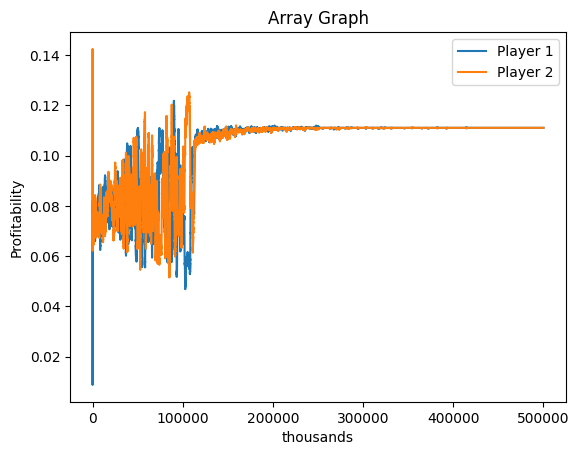

In [7]:
x_values = range(len(avg_profs1))

# Plot the array as a line graph
plt.plot(x_values, avg_profs1)
plt.plot(x_values, avg_profs2)

# Add labels and title
plt.xlabel('thousands')
plt.ylabel('Profitability')
plt.title('Array Graph')
plt.legend(['Player 1', 'Player 2'])

# Display the graph
plt.show()

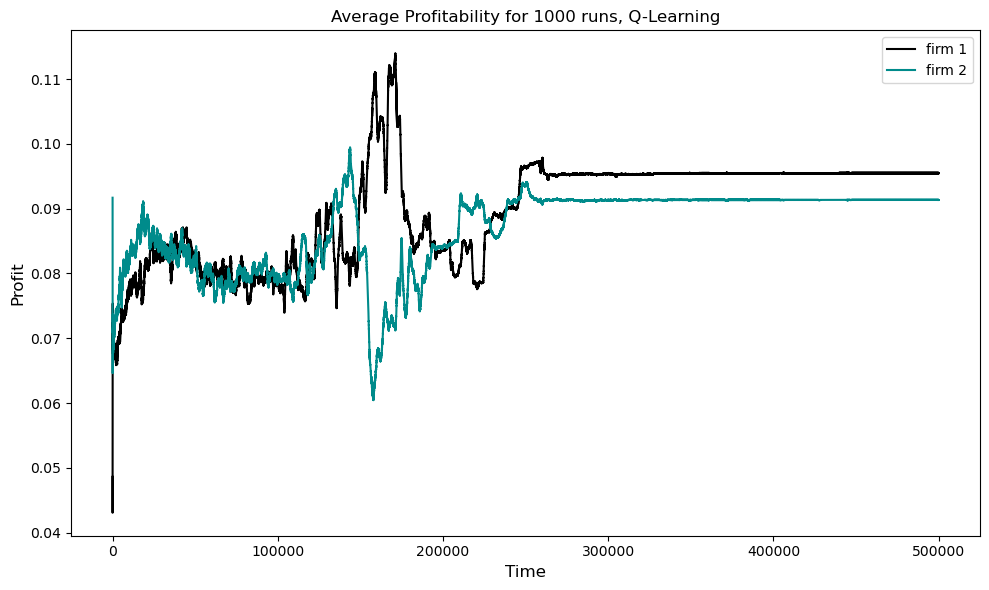

In [20]:
# %matplotlib tk
time = np.arange(T)
title = 'Average Profitability for 1000 runs, Q-Learning'
fig = avg_profits_plot(time[1:], profits_1_avgs[1:], profits_2_avgs[1:], title=title)

# WoLF-PHC vs sequential Q

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Shares of  Nash Equilibria 0.65
Shares of Non-optimal Nash Equilibria 0.5
Shares of Optimal Nash Equilibria 0.15
NE_counter 13
non_opt_NE_counter 10
opt_NE_counter 3


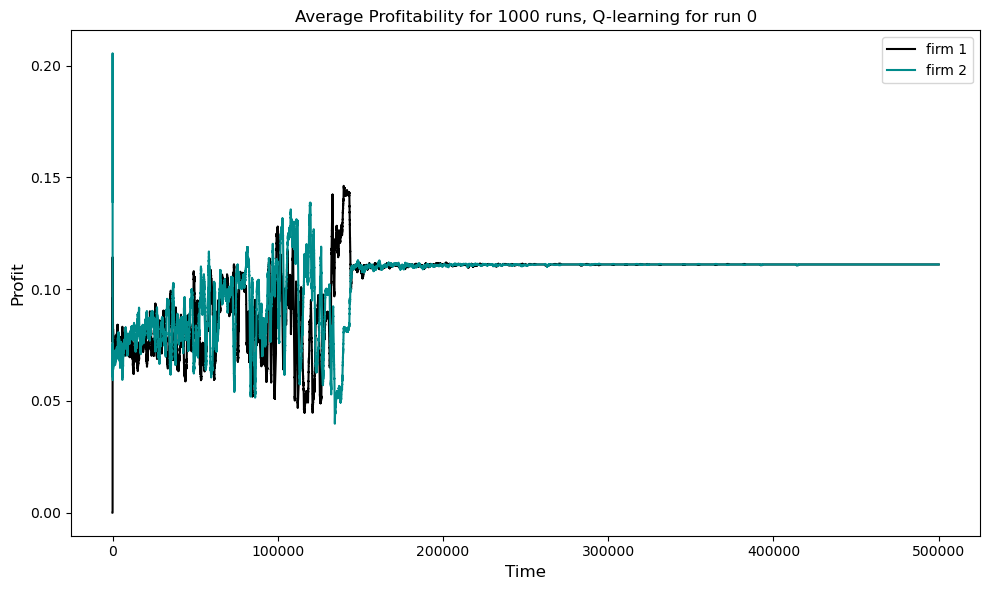

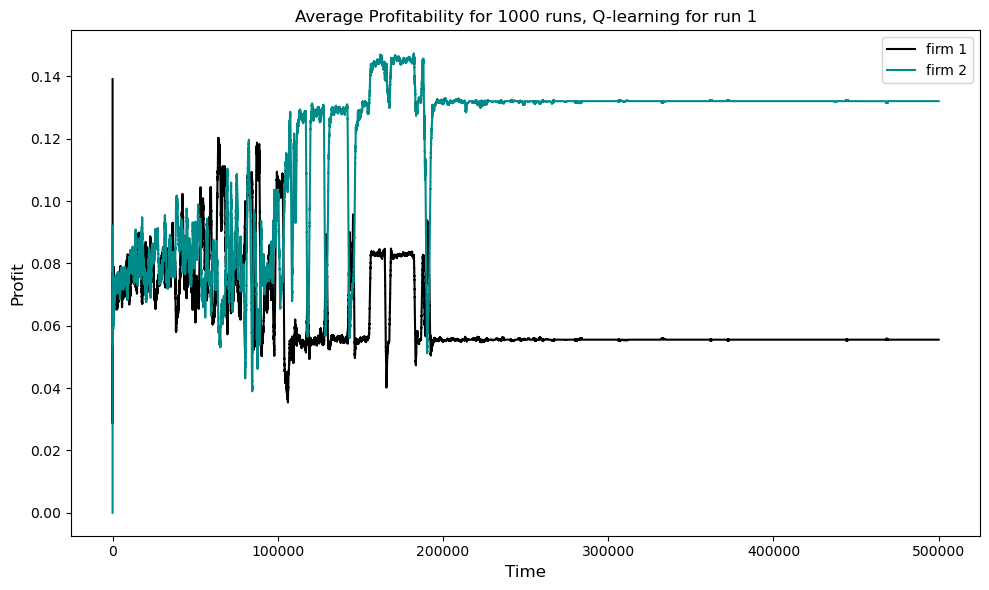

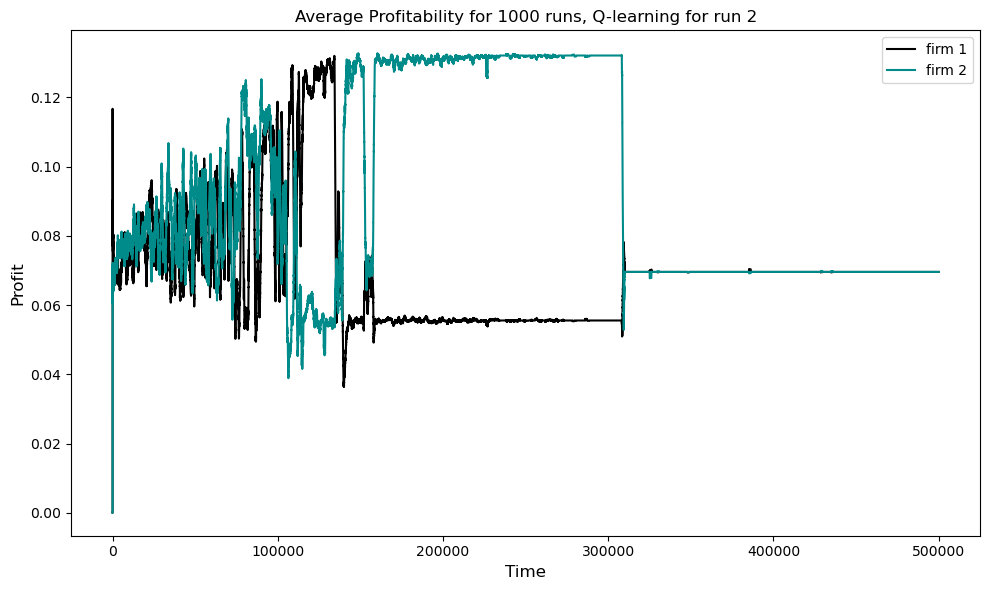

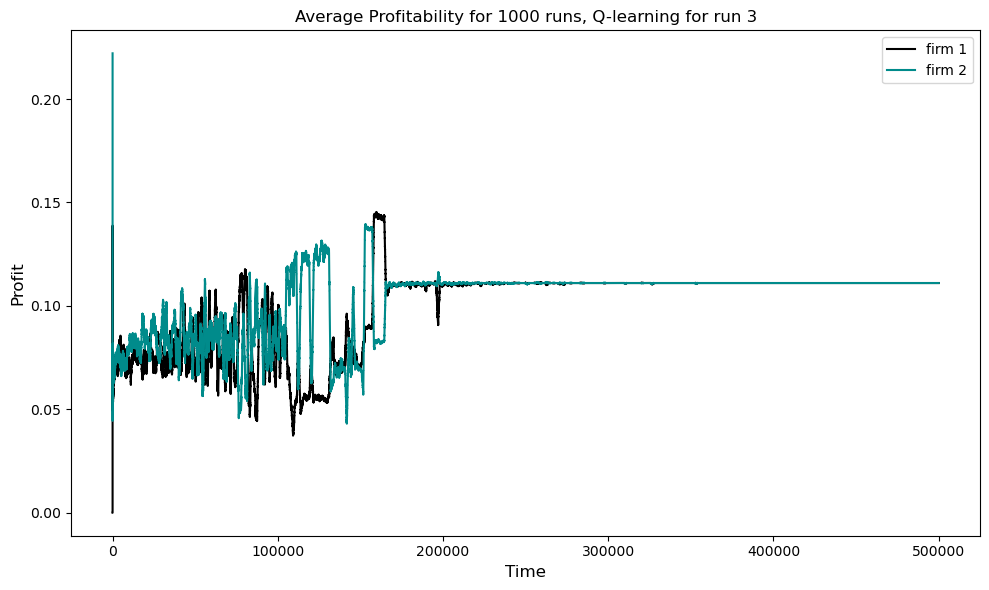

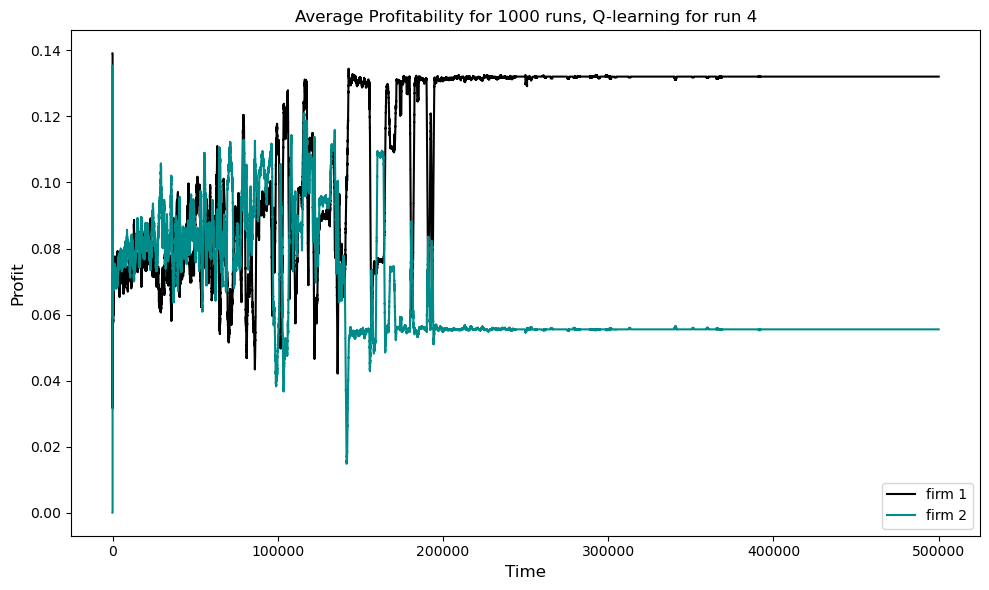

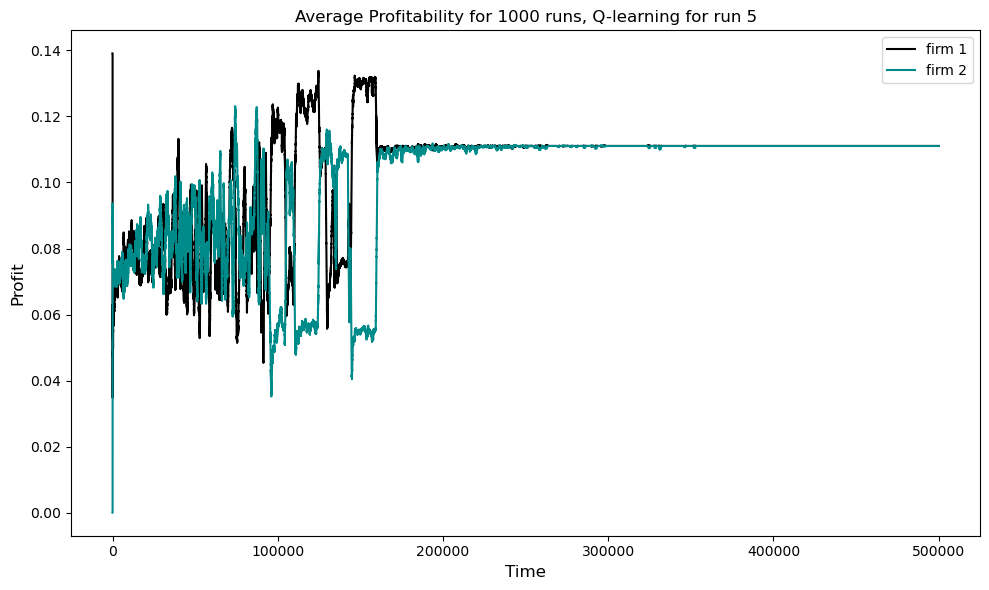

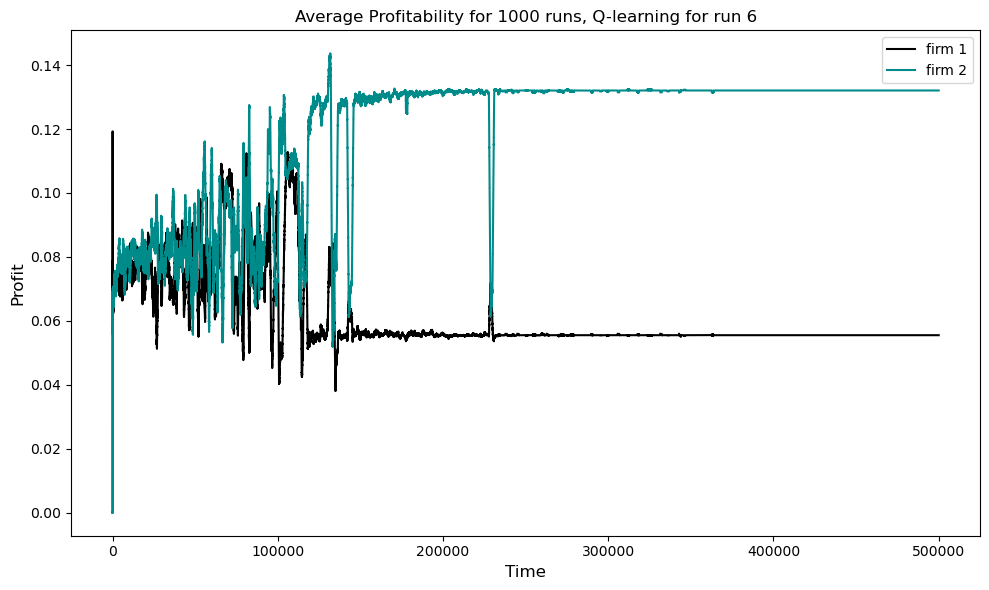

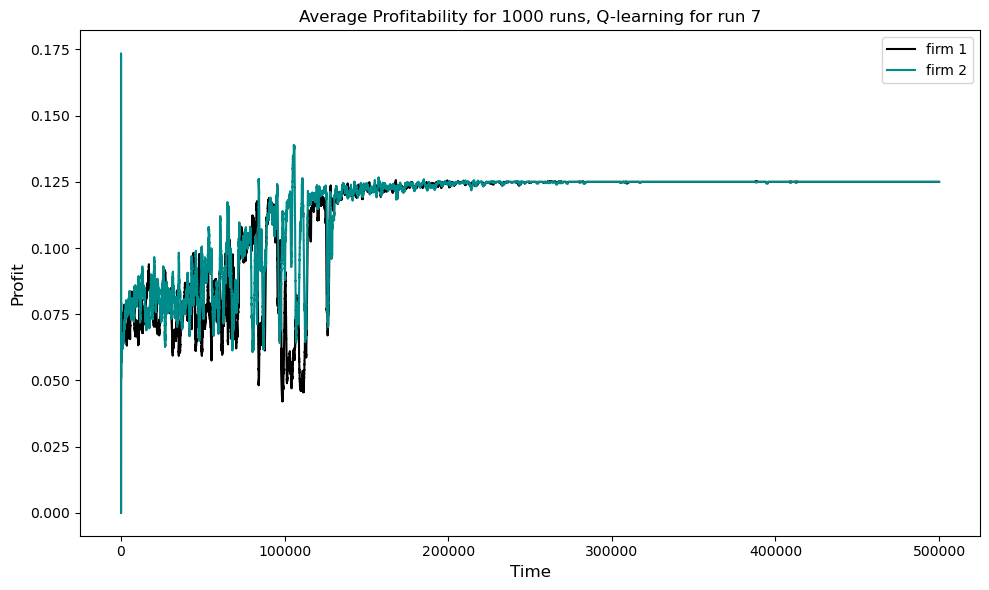

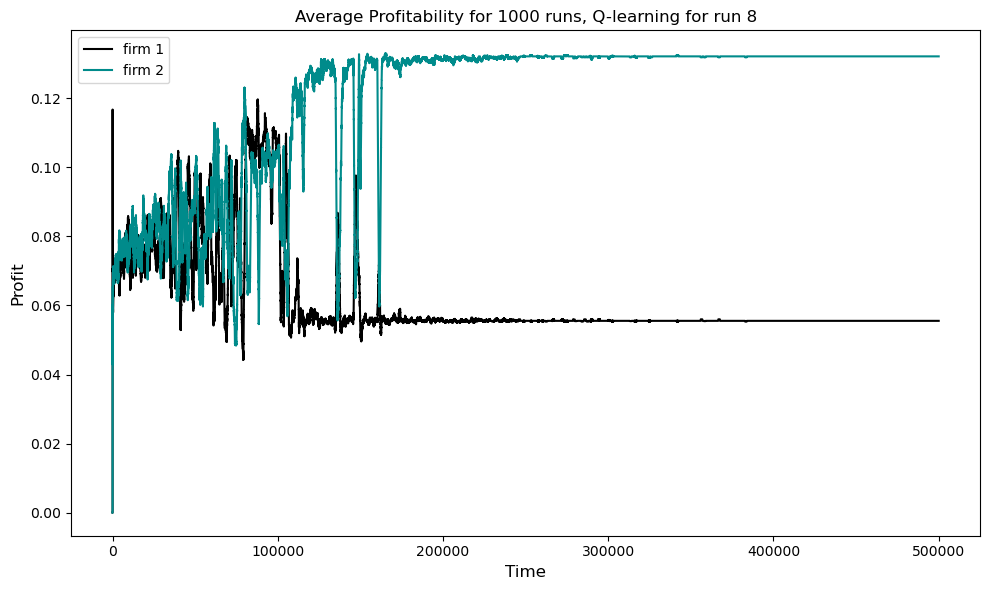

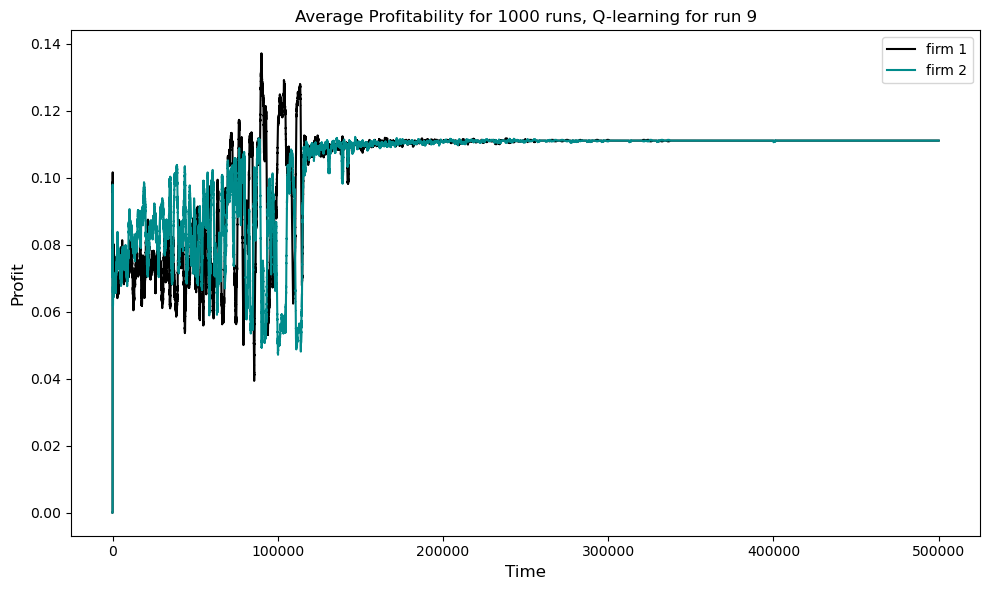

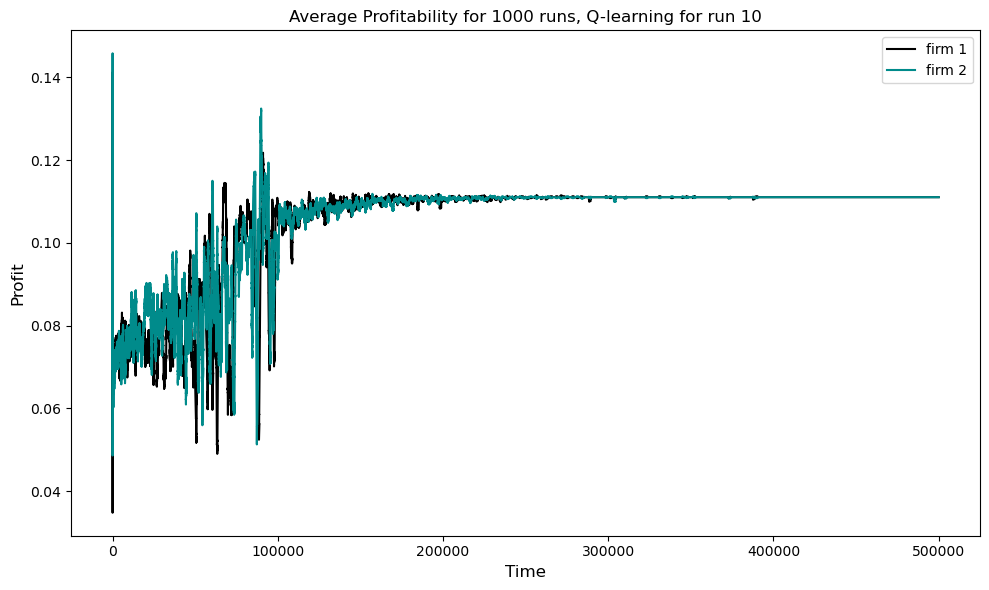

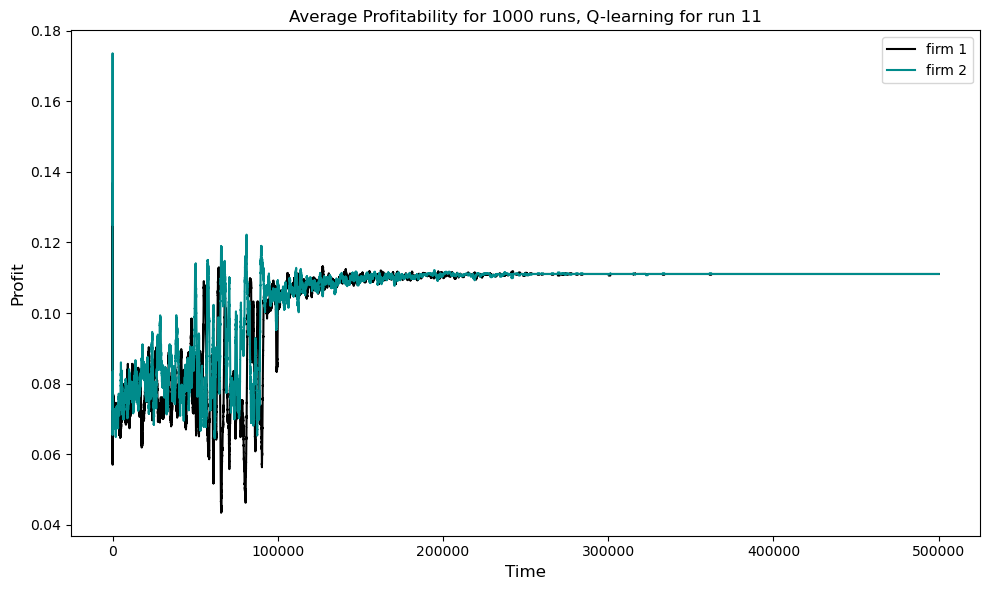

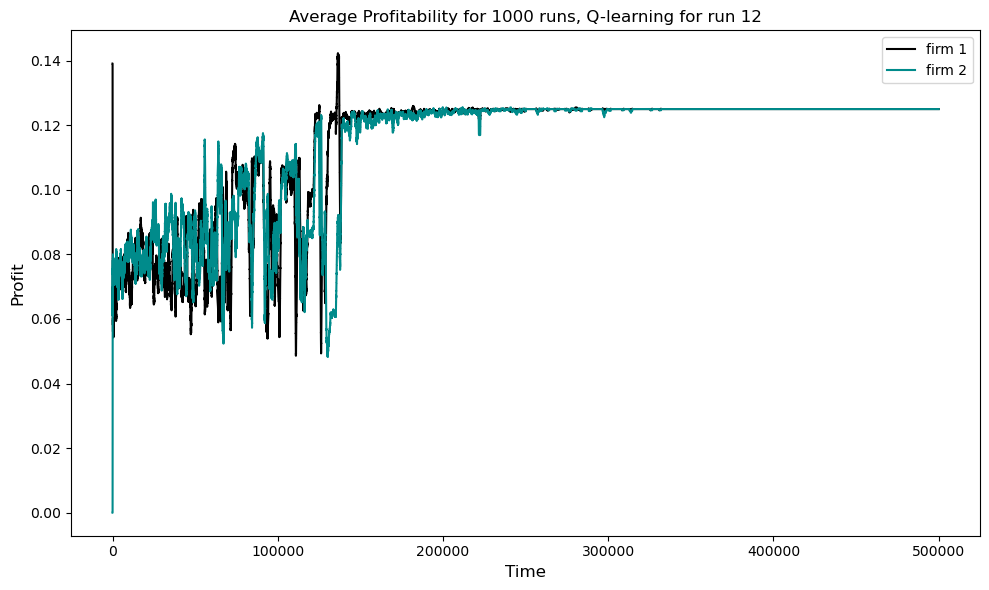

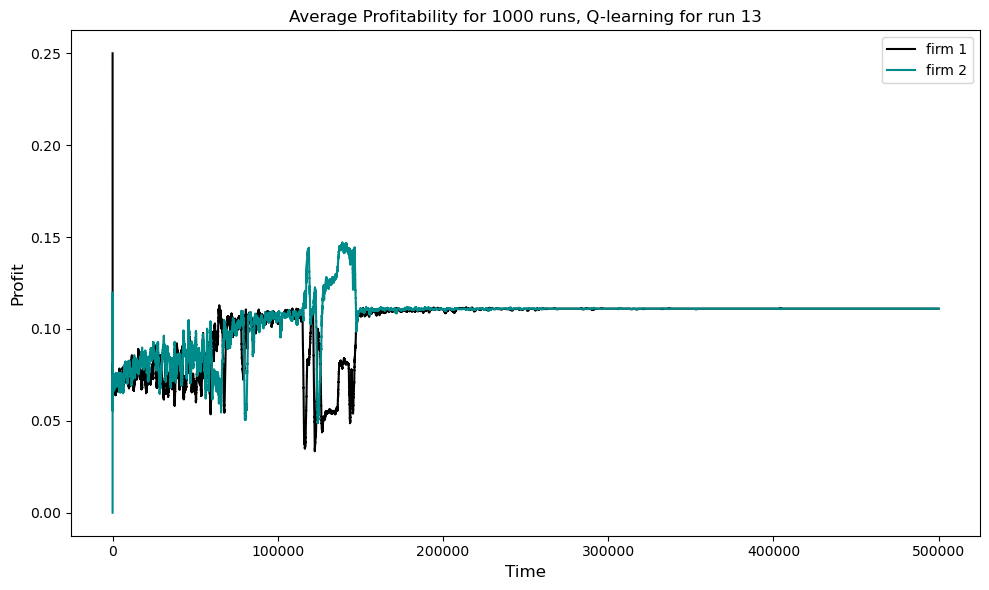

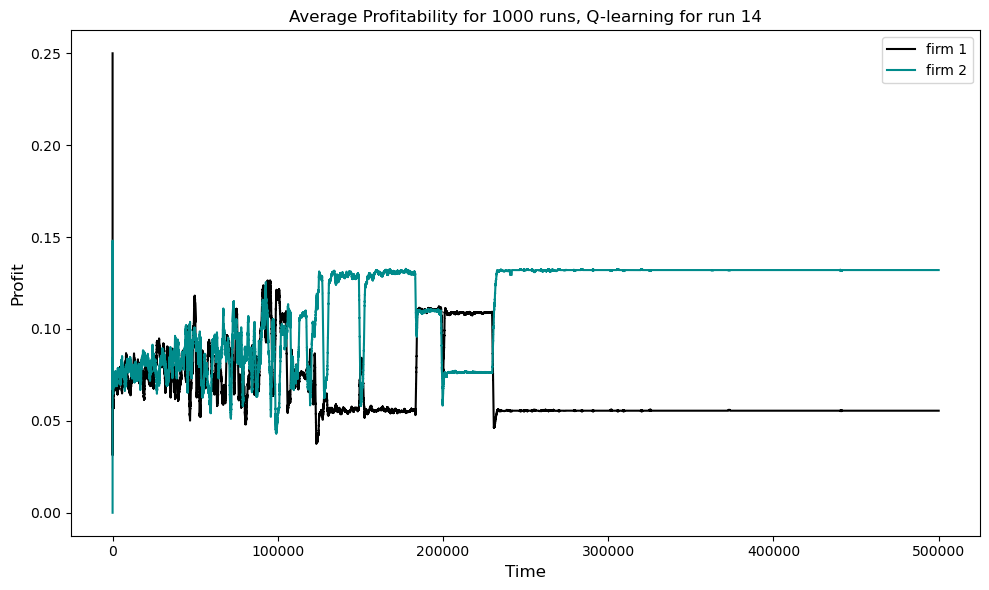

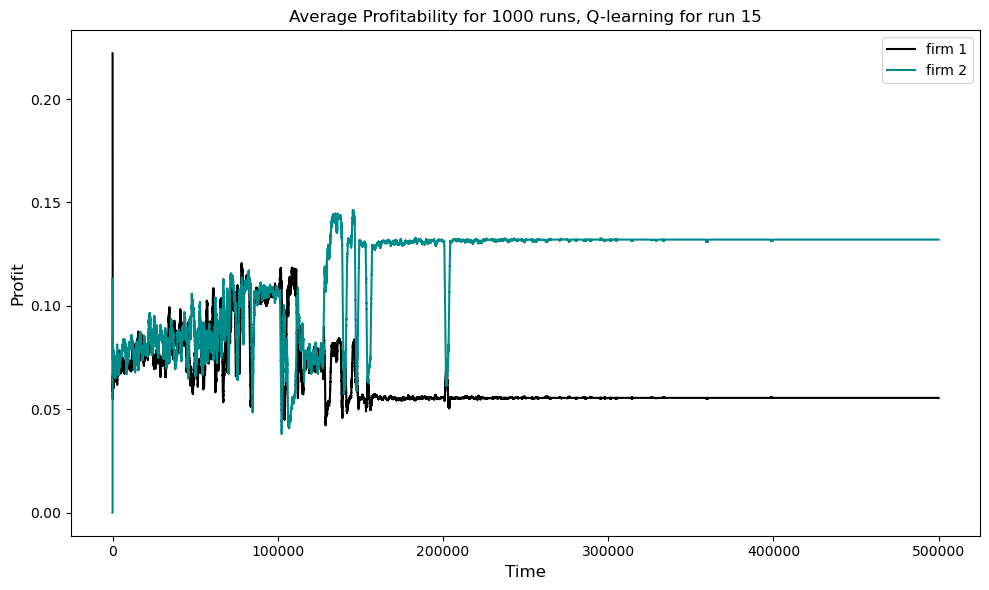

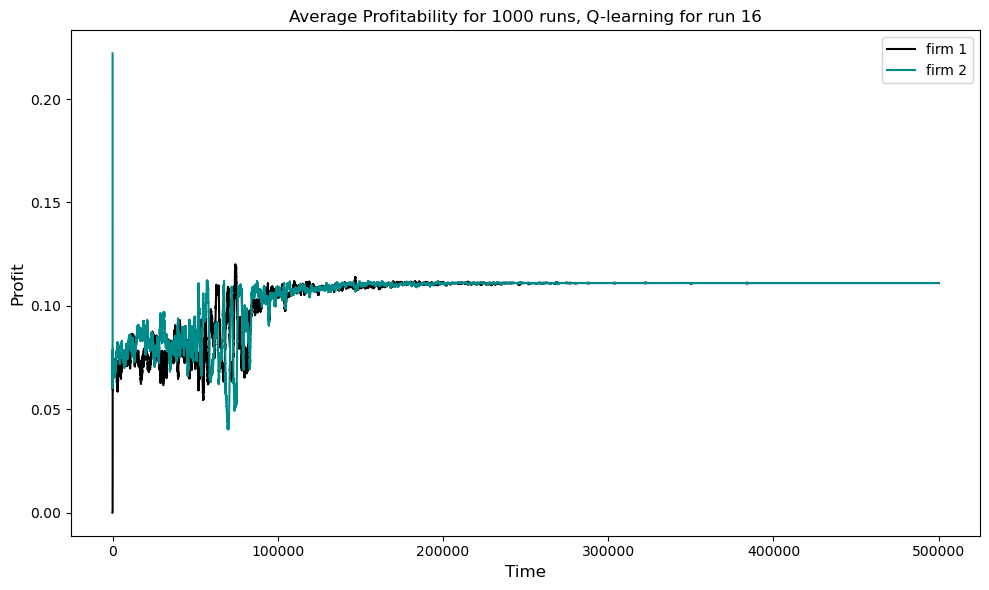

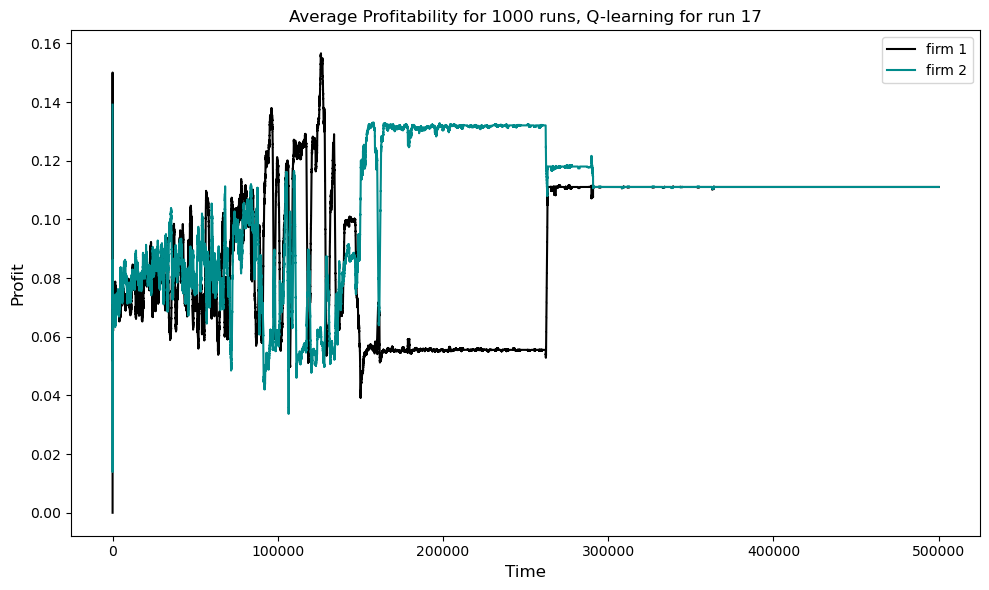

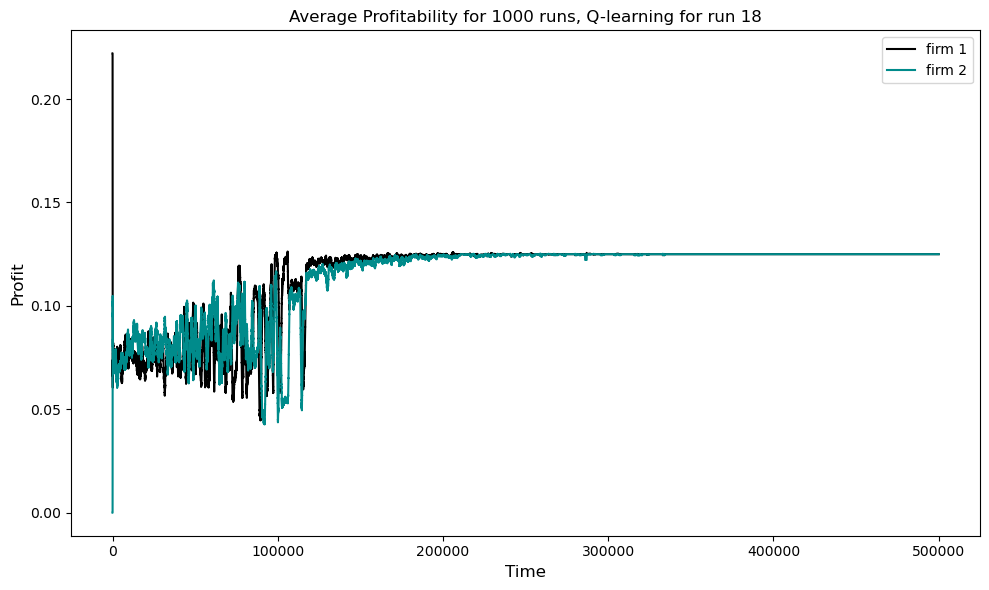

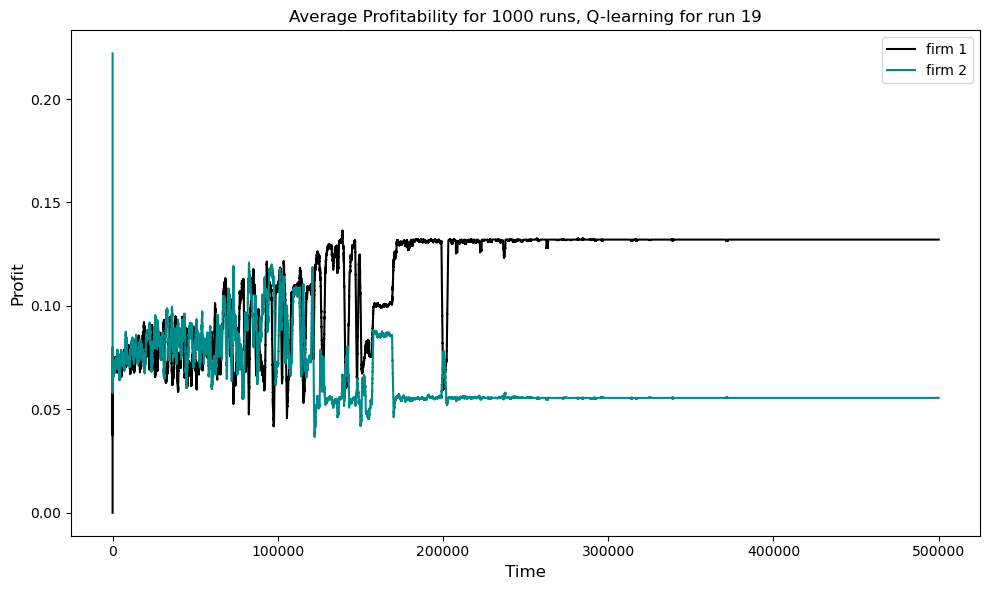

In [24]:
config.DISABLE_JIT = False
np.random.seed(2020)
T = 500000 # Iterations
gamma = 0.95 # Discount factor
alpha = 0.3 # Learning rate
theta = 0.0000275 # Parameter for exploration
delta_l = 0.6 # learning rate when losing
delta_w = 0.2 # l1earning rate when winning
k = 6 # Number of equally sized price intervals
s = np.round(np.arange(k + 1) / (np.zeros(k + 1) + k), 3)
t = np.arange(T + 2) + 1
epsilon = np.array([(1 - theta)**i for i in t])
# epsilon = np.zeros(T + 2) + 0.05
tau = np.logspace(1, -6, T + 2) # temperature parameter in Boltzman policy

@jit(nopython=True)
def select_action_egreedy(Q, current_s, a, epsilon, u):
    """Epsilon-greedy action selection.
    Args:
        Q: Q-function
        current_s: current state
        a: action vector containing the possible actions
        epsilon: probability of selecting an action uniformly at random
        u: draw from U(0,1) distribution
    Returns:
        the selected action
    """

    if u < epsilon:
        return np.random.choice(a)
    else:
        max_idx = np.argmax(Q[np.where(a == current_s)[0][0], :])
        return a[max_idx]

@jit(nopython=True)
def select_action_egreedy_WoLF(Q, current_s, a, epsilon, u, policy):
    """Epsilon-greedy action selection for WoLF-PHC.
    Args:
        Q: Q-function
        current_s: current state
        a: action vector containing the possible actions
        epsilon: probability of selecting an action uniformly at random
        u: draw from U(0,1) distribution
        policy: current stochastic policy according to policy hill climbing
    Returns:
        the selected action
    """
    if u < epsilon:
        return np.random.choice(a)
    else:
        cumsum = np.cumsum(policy[np.where(a == current_s)[0][0], :])
        idx = np.searchsorted(cumsum, np.array([u]))[0] 
        return a[idx]

# @jit(nopython=True)
# def select_action_boltzmann_WoLF(Q, current_s, s, tau, u):
#     """Boltzmann exploration procedure
#     tau: temperature parameter
#     """
#     exp_Q = np.exp(Q[np.where(s == current_s)[0][0], :] / tau) # Numerator
#     sum_Q = np.sum(exp_Q) # Denominator
#     if np.isinf(sum_Q):
#         max_idx = np.argmax(Q[np.where(s == current_s)[0][0], :])
#         return s[max_idx]
#     probs = exp_Q / sum_Q
#     # Select action according to probabilities
#     cumsum = np.cumsum(probs)
#     idx = np.searchsorted(cumsum, np.array([u]))[0] 
#     return s[idx]

@jit(nopython=True)
def profit(p_i, p_j):
    if p_i < p_j:
        d = 1 - p_i
    elif p_i == p_j:
        d =  0.5 * (1 - p_i)
    else:
        d = 0

    return p_i * d

def mode(x):
    """Returns mode of an array"""
    values, counts = np.unique(x, return_counts=True)
    m = counts.argmax()
    return values[m]

@jit(nopython=True)
def sequential_WoLF_PHC_learning(s, gamma, expl_param, alpha, u, select_action_1=select_action_egreedy_WoLF, select_action_2=select_action_egreedy):
    """Function for implementing (sequential) WoLF-PHC in the sequential duopoly model in Klein (2021).
    Args:
        s: state and action vector
        gamma: discount factor
        expl_param: exploration parameter, where expl_param=epsilon if e-greedy action selection, and expl_param=tau if Boltzmann action selection
        alpha: learning rate
        u: vector of draws from U(0,1)
        select_action: action selection strategy
    Returns:
        Q_1: estimate of optimal Q-function for firm 1
        Q_2: estimate of optimal Q-function for firm 2
        profits_1_avgs: Moving average profits of firm 1 based on 1000 time periods
        profits_2_avgs: Moving average profits of firm 2 based on 1000 time periods
        profits_1: realized profits of firm 1 in the last 1000 time periods
        profits_2: realized profits of firm 2 in the last 1000 time periods
    """

    # Initialize
    Q_1 = np.zeros((len(s), len(s)))
    Q_2 = np.zeros((len(s), len(s)))
    
    # Initialize stochastic policies as uniform distributions
    policy_1 = np.ones((len(s), len(s))) / len(s)

    # Estimates of expected value of the average policy for firm 1 and 2 respectively
    avg_policy_1 = np.ones((len(s), len(s))) / len(s)

    # Counter for every time state s is visited
    N_1 = np.zeros(len(s))
    N_2 = np.zeros(len(s))

    p_1 = np.random.choice(s)
    p_2 = np.random.choice(s)
    p_1_prime = np.random.choice(s)
    p_2_prime = np.random.choice(s)  

    # Average 1000 period profits
    profits_1 = np.empty(1000)
    profits_1[:] = np.nan
    profits_2 = np.empty(1000)
    profits_2[:] = np.nan
    profits_1_avgs = np.zeros(T)
    profits_2_avgs = np.zeros(T)

    for t in range(2, len(expl_param)):
        if (t % 2) == 0:
            p_1 = p_1_prime
            pi = profit(p_1, p_2)
            pi_prime = profit(p_1, p_2_prime)
            r_t = pi + gamma * pi_prime
            a_idx = np.where(s == p_1)[0][0]
            p_2_prime_idx = np.where(s == p_2_prime)[0][0]
            p_2_idx = np.where(s == p_2)[0][0]
            max_Q = max(Q_1[p_2_prime_idx, :])
            Q_1[p_2_idx, a_idx] = Q_1[p_2_idx, a_idx] + alpha * (r_t + gamma**2 * max_Q - Q_1[p_2_idx, a_idx])
            # Step closer to optimal policy wrt. Q
            N_1[p_2_idx] += 1
            avg_policy_1[p_2_idx, :] = avg_policy_1[p_2_idx, :] + (1 / N_1[p_2_idx]) * (policy_1[p_2_idx, :] - avg_policy_1[p_2_idx, :])
            avg_policy_1[p_2_idx, :] /= avg_policy_1[p_2_idx, :].sum() # To ensure a legal probability distribution
            if np.sum(Q_1[p_2_idx, :] * policy_1[p_2_idx, :]) > np.sum(Q_1[p_2_idx, :] * avg_policy_1[p_2_idx, :]):
                delta = delta_w
            else:
                delta = delta_l
            # delta_sa = - np.minimum(policy_1[p_2_idx, :], delta / (len(s) - 1))
            delta_sa = np.zeros(len(s)) - delta / (len(s) - 1)
            a_max_idx = np.argmax(Q_1[p_2_idx, :])
            delta_sa[a_max_idx] = - (delta_sa.sum() - delta_sa[a_max_idx])
            policy_1[p_2_idx, :] += delta_sa
            policy_1[p_2_idx, :] = np.minimum(1, np.maximum(policy_1[p_2_idx, :], 0))
            policy_1[p_2_idx, :] /= policy_1[p_2_idx, :].sum() # To ensure a legal probability distribution
            p_1_prime = select_action_1(Q_1, p_2_prime, s, expl_param[t], u[t], policy_1)
            profits_1 = np.concatenate((np.array([pi]), profits_1[0:-1]))
            profits_1_avgs[t - 2] = np.nanmean(profits_1)
            pi_2 = profit(p_2, p_1)
            profits_2 = np.concatenate((np.array([pi_2]), profits_2[0:-1]))
            profits_2_avgs[t - 2] = np.nanmean(profits_2)
        else:
            p_2 = p_2_prime
            pi = profit(p_2, p_1)
            pi_prime = profit(p_2, p_1_prime)
            r_t = pi + gamma * pi_prime
            a_idx = np.where(s == p_2)[0][0]
            p_1_prime_idx = np.where(s == p_1_prime)[0][0]
            p_1_idx = np.where(s == p_1)[0][0]
            p_2_prime = select_action_2(Q_2, p_1_prime, s, expl_param[t], u[t])
            p_2_prime_idx = np.where(s == p_2_prime)[0][0]
            Q_2[p_1_idx, a_idx] = Q_2[p_1_idx, a_idx] + alpha * (r_t + gamma**2 * Q_2[p_1_prime_idx, p_2_prime_idx] - Q_2[p_1_idx, a_idx])
            profits_2 = np.concatenate((np.array([pi]), profits_2[0:-1]))
            profits_2_avgs[t - 2] = np.nanmean(profits_2)
            pi_1 = profit(p_1, p_2)
            profits_1 = np.concatenate((np.array([pi_1]), profits_1[0:-1]))
            profits_1_avgs[t - 2] = np.nanmean(profits_1)

    return Q_1, Q_2, profits_1_avgs, profits_2_avgs, profits_1, profits_2

# Simulation with n repetitions
n = 20 # Repetitions
u = np.random.uniform(size=(n, T + 2))
profits_1_avgs = np.zeros((n, T))
profits_2_avgs = np.zeros((n, T))
opt_profit = 0.125 # Joint maximizing profit
time = np.arange(T)

non_opt_NE_counter = 0 # Non-optimal Nash Equilibrium Counter
opt_NE_counter = 0 # Optimal Nash Equilibium Counter

for i in range(n):
    _, _, profits_1_avgs[i, :], profits_2_avgs[i, :], profits_1, profits_2 = sequential_WoLF_PHC_learning(s, gamma, epsilon, alpha,  u[i, :], select_action_1=select_action_egreedy_WoLF, select_action_2=select_action_egreedy)
    
    title = f'Average Profitability for 1000 runs, Q-learning for run {i}'
    fig = avg_profits_plot(time, profits_1_avgs[i, :], profits_2_avgs[i, :], title=title)

    mode_1, mode_2 = mode(profits_1), mode(profits_2)
    if sum(profits_1 == mode_1) > 990 and sum(profits_2 == mode_2) > 990:
        if mode_1 == mode_2 == opt_profit:
            opt_NE_counter += 1
        elif mode_1 == mode_2:
            non_opt_NE_counter += 1
    print(i)

# Avg. profits over 1000 time periods
profits_1_avgs = np.mean(profits_1_avgs, axis=0)
profits_2_avgs = np.mean(profits_2_avgs, axis=0)

# Shares of Nash Equilibria
NE_counter = non_opt_NE_counter + opt_NE_counter
NE_shares = NE_counter / n
non_opt_NE_shares = non_opt_NE_counter / n
opt_NE_shares = opt_NE_counter / n

print("Shares of  Nash Equilibria", NE_shares)
print("Shares of Non-optimal Nash Equilibria", non_opt_NE_shares)
print("Shares of Optimal Nash Equilibria", opt_NE_shares)
print("NE_counter", NE_counter)
print("non_opt_NE_counter", non_opt_NE_counter)
print("opt_NE_counter", opt_NE_counter)

# lp = LineProfiler()
# lp_wrapper = lp(sequential_WoLF_PHC_learning)
# lp_wrapper(s, gamma, epsilon, alpha, u[0, :], select_action=select_action_egreedy_WoLF)
# lp.print_stats()

# Policy Gradient Method - REINFORCE

In [32]:
config.DISABLE_JIT = False
T = 500000 # Iterations
delta = 0.95 # Discount factor
alpha = 0.3 # Learning rate in Q-learning
omega = 0.1 # Learning rate in policy gradient step
theta = 0.0000275 # Parameter for exploration
k = 6 # Number of equally sized price intervals
s = np.round(np.arange(k + 1) / (np.zeros(k + 1) + k), 3)
t = np.arange(T + 2) + 1
epsilon = np.array([(1 - theta)**i for i in t])
tau = np.logspace(1, -6, T + 2) # temperature parameter in Boltzman policy

@jit(nopython=True)
def select_action(Q, current_s, s, epsilon, u, policy):
    # """Epsilon-greedy action selection"""
    # if u < epsilon:
    #     return np.random.choice(s)
    # else:
    cumsum = np.cumsum(policy)
    idx = np.searchsorted(cumsum, np.array([u]))[0] 
    return s[idx]

# @jit(nopython=True)
# def select_action(Q, current_s, s, tau, u):
#     """Boltzmann exploration procedure
#     tau: temperature parameter
#     """
#     exp_Q = np.exp(Q[np.where(s == current_s)[0][0], :] / tau) # Numerator
#     sum_Q = np.sum(exp_Q) # Denominator
#     if np.isinf(sum_Q):
#         max_idx = np.argmax(Q[np.where(s == current_s)[0][0], :])
#         return s[max_idx]
#     probs = exp_Q / sum_Q
#     # Select action according to probabilities
#     cumsum = np.cumsum(probs)
#     idx = np.searchsorted(cumsum, np.array([u]))[0] 
#     return s[idx]

@jit(nopython=True)
def profit(p_i, p_j):
    if p_i < p_j:
        d = 1 - p_i
    elif p_i == p_j:
        d =  0.5 * (1 - p_i)
    else:
        d = 0

    return p_i * d

def mode(x):
    """Returns mode of an array"""
    values, counts = np.unique(x, return_counts=True)
    m = counts.argmax()
    return values[m]

@jit(nopython=True)   
def policy(current_s, w):
	z = current_s.dot(w)
	exp = np.exp(z)
	return exp/np.sum(exp)

# Vectorized softmax Jacobian
@jit(nopython=True)   
def softmax_grad(softmax):
    s = softmax.reshape(-1,1)
    b = np.zeros((len(s), len(s)))
    np.fill_diagonal(b, s[:, 0])
    return b - np.dot(s, s.T)
    # return np.diagflat(s) - np.dot(s, s.T)



@jit(nopython=True)
def sequential_QAC(s, delta, epsilon, alpha, u):
    # Initialize
    Q_1 = np.zeros((len(s), len(s)))
    Q_2 = np.zeros((len(s), len(s)))

    # policy_1 = Softmax_policy(len(s), len(s)) # No. of actions and No. of features (using one-hot encoding)
    # policy_2 = Softmax_policy(len(s), len(s)) # No. of actions and No. of features (using one-hot encoding)

    w_1 = np.zeros((len(s), len(s))) # Initial weights for firm 1
    w_2 = np.zeros((len(s), len(s))) # Initial weights for firm 2

    p_1 = 0
    p_2 = 1 # Set to 1 to mimic that firm 2 has not entered market yet
    s_feature_1_prime = np.zeros((1, len(s)))
    s_feature_1_prime[0, np.where(s == p_2)[0][0]] = 1
    p_1_prime = select_action(Q_1, p_2, s, epsilon[0], u[0], policy(s_feature_1_prime, w_1))
    s_feature_2_prime = np.zeros((1, len(s)))
    s_feature_2_prime[0, np.where(s == p_1_prime)[0][0]] = 1
    p_2_prime = select_action(Q_2, p_1_prime, s, epsilon[1], u[1], policy(s_feature_2_prime, w_2))   

    # Average 1000 period profits
    profits_1 = np.empty(1000)
    profits_1[:] = np.nan
    profits_2 = np.empty(1000)
    profits_2[:] = np.nan
    profits_1_avgs = np.zeros(T)
    profits_2_avgs = np.zeros(T)

    for t in range(2, len(epsilon)):
        if (t % 2) == 0:
            p_1 = p_1_prime
            pi = profit(p_1, p_2)
            pi_prime = profit(p_1, p_2_prime)
            r_t = pi + delta * pi_prime
            a_idx = np.where(s == p_1)[0][0]
            p_2_prime_idx = np.where(s == p_2_prime)[0][0]
            p_2_idx = np.where(s == p_2)[0][0]
            s_feature_1_prime = np.zeros((1, len(s)))
            s_feature_1_prime[0, p_2_prime_idx] = 1
            p_1_prime = select_action(Q_1, p_2_prime, s, epsilon[t], u[t], policy(s_feature_1_prime, w_1))
            p_1_prime_idx = np.where(s == p_1_prime)[0][0]
            Q_1[p_2_idx, a_idx] = Q_1[p_2_idx, a_idx] + alpha * (r_t + delta**2 * Q_1[p_2_prime_idx, p_1_prime_idx] - Q_1[p_2_idx, a_idx])
            # max_Q = max(Q_1[p_2_prime_idx, :])
            # Q_1[p_2_idx, a_idx] = Q_1[p_2_idx, a_idx] + alpha * (r_t + delta**2 * max_Q - Q_1[p_2_idx, a_idx])
            s_feature_1 = np.zeros((1, len(s))) # one-hot encoding
            s_feature_1[0, p_2_idx] = 1
            probs_1 = policy(s_feature_1, w_1)
            dsoftmax_1 = softmax_grad(probs_1)[a_idx, :]
            dlog_1 = dsoftmax_1 / probs_1[0, a_idx]
            grad_1 = s_feature_1.T.dot(dlog_1.reshape(1, -1))
            w_1 += omega * grad_1 * Q_1[p_2_idx, a_idx]
            # max_Q1 = max(Q_1[p_2_prime_idx, :]) - max(Q_1[p_2_idx, :])
            # w_1 += omega * grad_1 *(r_t + delta**2 * max_Q1)
            # incr = omega * policy_1.gradient_log_pi(s_feature_1, a_idx) * Q_1[p_2_idx, a_idx]
            # policy_1.inc(incr)
            # s_feature_1_prime = np.zeros((1, len(s)))
            # s_feature_1_prime[0, p_2_prime_idx] = 1
            # p_1_prime = select_action(Q_1, p_2_prime, s, epsilon[t], u[t], policy(s_feature_1_prime, w_1))
            profits_1 = np.concatenate((np.array([pi]), profits_1[0:-1]))
            profits_1_avgs[t - 2] = np.nanmean(profits_1)
            pi_2 = profit(p_2, p_1)
            profits_2 = np.concatenate((np.array([pi_2]), profits_2[0:-1]))
            profits_2_avgs[t - 2] = np.nanmean(profits_2)
        else:
            p_2 = p_2_prime
            pi = profit(p_2, p_1)
            pi_prime = profit(p_2, p_1_prime)
            r_t = pi + delta * pi_prime
            a_idx = np.where(s == p_2)[0][0]
            p_1_prime_idx = np.where(s == p_1_prime)[0][0]
            p_1_idx = np.where(s == p_1)[0][0]
            s_feature_2_prime = np.zeros((1, len(s)))
            s_feature_2_prime[0, p_1_prime_idx] = 1
            p_2_prime = select_action(Q_2, p_1_prime, s, epsilon[t], u[t], policy(s_feature_2_prime, w_2))
            p_2_prime_idx = np.where(s == p_2_prime)[0][0]
            Q_2[p_1_idx, a_idx] = Q_2[p_1_idx, a_idx] + alpha * (r_t + delta**2 * Q_2[p_1_prime_idx, p_2_prime_idx] - Q_2[p_1_idx, a_idx])
            # max_Q = max(Q_2[p_1_prime_idx, :])
            # Q_2[p_1_idx, a_idx] = Q_2[p_1_idx, a_idx] + alpha * (r_t + delta**2 * max_Q - Q_2[p_1_idx, a_idx])
            s_feature_2 = np.zeros((1, len(s))) # one-hot encoding
            s_feature_2[0, p_1_idx] = 1
            probs_2 = policy(s_feature_2, w_2)
            dsoftmax_2 = softmax_grad(probs_2)[a_idx, :]
            dlog_2 = dsoftmax_2 / probs_2[0, a_idx]
            grad_2 = s_feature_2.T.dot(dlog_2.reshape(1, -1))
            w_2 += omega * grad_2 * Q_2[p_1_idx, a_idx]
            # max_Q2 = max(Q_2[p_1_prime_idx, :]) - max(Q_2[p_1_idx, :])
            # w_2 += omega * grad_2 * (r_t + delta**2 * max_Q2)
            # incr = omega * policy_2.gradient_log_pi(s_feature_2, a_idx) * Q_2[p_1_idx, a_idx]
            # policy_2.inc(incr)
            # s_feature_2_prime = np.zeros((1, len(s)))
            # s_feature_2_prime[0, p_1_prime_idx] = 1
            # p_2_prime = select_action(Q_2, p_1_prime, s, epsilon[t], u[t], policy(s_feature_2_prime, w_2))
            profits_2 = np.concatenate((np.array([pi]), profits_2[0:-1]))
            profits_2_avgs[t - 2] = np.nanmean(profits_2)
            pi_1 = profit(p_1, p_2)
            profits_1 = np.concatenate((np.array([pi_1]), profits_1[0:-1]))
            profits_1_avgs[t - 2] = np.nanmean(profits_1)

    return Q_1, Q_2, profits_1_avgs, profits_2_avgs, profits_1, profits_2


# Simulation with n repetitions
n = 100 # Repetitions
u = np.random.uniform(size=(n, T + 2))
profits_1_avgs = np.zeros((n, T))
profits_2_avgs = np.zeros((n, T))
profits_1 = np.zeros((n, 1000))
profits_2 = np.zeros((n, 1000))
opt_profit = 0.125 # Joint maximizing profit
time = np.arange(T)

non_opt_NE_counter_low = 0 # Non-optimal Nash Equilibrium Counter for collusive around 0.167
non_opt_NE_counter_high = 0 # Non-optimal Nash Equilibrium Counter for collusive around 0.333
semi_collusive_counter = 0
opt_NE_counter = 0 # Optimal Nash Equilibium Counter

for i in range(n):
    _, _, profits_1_avgs[i, :], profits_2_avgs[i, :], profits_1[i, :], profits_2[i, :] = sequential_QAC(s, delta, epsilon, alpha, u[i, :])
    
    # title = f'Average Profitability for 1000 runs, Q-learning for run {i}'
    # fig = avg_profits_plot(time, profits_1_avgs[i, :], profits_2_avgs[i, :], title=title)

    mode_1, mode_2 = mode(profits_1[i, :]), mode(profits_2[i, :])
    if sum(profits_1[i, :] == mode_1) > 980 and sum(profits_2[i, :] == mode_2) > 980:
        if round(mode_1, 4) == round(mode_2, 4) == round(opt_profit, 4):
            opt_NE_counter += 1
        elif round(mode_1, 4) == round(mode_2, 4) == round(profit(s[1], s[1]), 4):
            non_opt_NE_counter_low += 1
        elif round(mode_1, 4) == round(mode_2, 4) == round(profit(s[2], s[2]), 4):
            non_opt_NE_counter_high += 1
    elif 0.1144 < np.mean(profits_1[i, :]) < 0.1146 and 0.1144 < np.mean(profits_2[i, :]) < 0.1146:
        semi_collusive_counter += 1
    # print(i)

# Avg. profits over 1000 time periods
profits_1_avgs = np.mean(profits_1_avgs, axis=0)
profits_2_avgs = np.mean(profits_2_avgs, axis=0)

# Shares of Nash Equilibria
NE_counter = non_opt_NE_counter_low + non_opt_NE_counter_high + opt_NE_counter
NE_shares = NE_counter / n
non_opt_NE_shares = (non_opt_NE_counter_low + non_opt_NE_counter_high) / n
non_opt_NE_shares_low = non_opt_NE_counter_low / n
non_opt_NE_shares_high = non_opt_NE_counter_high / n
opt_NE_shares = opt_NE_counter / n

print("Shares of  Nash Equilibria", NE_shares)
print("Shares of Non-optimal Nash Equilibria", non_opt_NE_shares)
print("Shares of Non-optimal Nash Equilibria - LOW", non_opt_NE_shares_low)
print("Shares of Non-optimal Nash Equilibria - HIGH", non_opt_NE_shares_high)
print("Shares of Optimal Nash Equilibria", opt_NE_shares)
print("NE_counter", NE_counter)
print("non_opt_NE_counter_low", non_opt_NE_counter_low)
print("non_opt_NE_counter_high", non_opt_NE_counter_high)
print("opt_NE_counter", opt_NE_counter)
print("semi_collusive_counter", semi_collusive_counter)

# lp = LineProfiler()
# lp_wrapper = lp(sequential_QAC)
# lp_wrapper(s, delta, epsilon, alpha, u[0, :])
# lp.print_stats()

Shares of  Nash Equilibria 0.52
Shares of Non-optimal Nash Equilibria 0.47
Shares of Non-optimal Nash Equilibria - LOW 0.22
Shares of Non-optimal Nash Equilibria - HIGH 0.25
Shares of Optimal Nash Equilibria 0.05
NE_counter 52
non_opt_NE_counter_low 22
non_opt_NE_counter_high 25
opt_NE_counter 5
semi_collusive_counter 0


In [159]:
%matplotlib tk
time = np.arange(T)
title = 'Average Profitability for 1000 runs, Q-Learning'
fig = avg_profits_plot(time[1:], profits_1_avgs[1:], profits_2_avgs[1:], title=title)

Exception ignored in: <function Variable.__del__ at 0x000001FD1422D670>
Traceback (most recent call last):
  File "c:\Users\Juliu\anaconda3\envs\OreL\lib\tkinter\__init__.py", line 363, in __del__
    if self._tk.getboolean(self._tk.call("info", "exists", self._name)):
RuntimeError: main thread is not in main loop
Exception ignored in: <function Variable.__del__ at 0x000001FD1422D670>
Traceback (most recent call last):
  File "c:\Users\Juliu\anaconda3\envs\OreL\lib\tkinter\__init__.py", line 363, in __del__
    if self._tk.getboolean(self._tk.call("info", "exists", self._name)):
RuntimeError: main thread is not in main loop
Exception ignored in: <function Variable.__del__ at 0x000001FD1422D670>
Traceback (most recent call last):
  File "c:\Users\Juliu\anaconda3\envs\OreL\lib\tkinter\__init__.py", line 363, in __del__
    if self._tk.getboolean(self._tk.call("info", "exists", self._name)):
RuntimeError: main thread is not in main loop
Exception ignored in: <function Variable.__del__ at 

# COLF and CK

In [44]:
config.DISABLE_JIT = False
np.random.seed(2020)
T = 500000 # Iterations
delta = 0.95 # Discount factor
alpha = 0.3 # Learning rate
# alpha_s = 0.8 # Stationary payoffs
# alpha_ns = 0.1 # Non-Stationary payoffs
# alpha_s = 0.6 # Stationary payoffs
# alpha_ns = 0.2 # Non-Stationary payoffs
# alpha_s = 0.4 # Stationary payoffs
# alpha_ns = 0.1 # Non-Stationary payoffs
alpha_s = 0.6 # Stationary payoffs
alpha_ns = 0.1 # Non-Stationary payoffs
lambdaa = 0.1 # Weight factor
theta = 0.0000275 # Parameter for exploration
k = 6 # Number of equally sized price intervals
s = np.round(np.arange(k + 1) / (np.zeros(k + 1) + k), 3)
t = np.arange(T + 2) + 1
epsilon = np.array([(1 - theta)**i for i in t])
tau = np.logspace(1, -6, T + 2) # temperature parameter in Boltzman policy

@jit(nopython=True)
def select_action_egreedy_joint(Q, current_s_p1, current_s_p2, a, epsilon, u):
    """Epsilon-greedy action selection for two-dimensional state space.
    Args:
        Q: Q-function
        current_s: current state
        a: action vector containing the possible actions
        epsilon: probability of selecting an action uniformly at random
        u: draw from U(0,1) distribution
    Returns:
        the selected action
    """
    if u < epsilon:
        return np.random.choice(a)
    else:
        max_idx = np.argmax(Q[np.where(a == current_s_p1)[0][0], np.where(a == current_s_p2)[0][0], :])
        return a[max_idx]

@jit(nopython=True)
def select_action_boltzmann_joint(Q, current_s_p1, current_s_p2, a, tau, u):
    """Boltzmann action selection for two-dimensional state space.
    Args:
        Q: Q-function
        current_s: current state
        a: action vector containing the possible actions
        epsilon: probability of selecting an action uniformly at random
        tau: temperature parameter
        u: draw from U(0,1) distribution
    Returns:
        the selected action
    """
    exp_Q = np.exp(Q[np.where(a == current_s_p1)[0][0], np.where(a == current_s_p2)[0][0], :] / tau) # Numerator
    sum_Q = np.sum(exp_Q) # Denominator
    if np.isinf(sum_Q):
        max_idx = np.argmax(Q[np.where(a == current_s_p1)[0][0], np.where(a == current_s_p2)[0][0], :])
        return a[max_idx]
    probs = exp_Q / sum_Q
    # Select action according to probabilities
    cumsum = np.cumsum(probs)
    idx = np.searchsorted(cumsum, np.array([u]))[0] 
    return a[idx]

@jit(nopython=True)
def profit(p_i, p_j):
    if p_i < p_j:
        d = 1 - p_i
    elif p_i == p_j:
        d =  0.5 * (1 - p_i)
    else:
        d = 0

    return p_i * d

def mode(x):
    """Returns mode of an array"""
    values, counts = np.unique(x, return_counts=True)
    m = counts.argmax()
    return values[m]

@jit(nopython=True)
def sequential_Q_learning_joint(s, delta, expl_param, alpha, u, select_action=select_action_egreedy_joint):
    """Function for implementing sequential Q-learning in the sequential duopoly model in Klein (2021) with two-dimensional state space.
    Args:
        s: state and action vector
        gamma: discount factor
        expl_param: exploration parameter, where expl_param=epsilon if e-greedy action selection, and expl_param=tau if Boltzmann action selection
        alpha: learning rate
        u: vector of draws from U(0,1)
        select_action: action selection strategy
    Returns:
        Q_1: estimate of optimal Q-function for firm 1
        Q_2: estimate of optimal Q-function for firm 2
        profits_1_avgs: Moving average profits of firm 1 based on 1000 time periods
        profits_2_avgs: Moving average profits of firm 2 based on 1000 time periods
        profits_1: realized profits of firm 1 in the last 1000 time periods
        profits_2: realized profits of firm 2 in the last 1000 time periods
    """

    # Initialize
    Q_1 = np.zeros((len(s), len(s), len(s)))
    Q_2 = np.zeros((len(s), len(s), len(s)))

    p_1 = np.random.choice(s)
    p_2 = np.random.choice(s)
    p_1_prime = np.random.choice(s)
    p_2_prime = np.random.choice(s)  


    # Average 1000 period profits
    profits_1 = np.empty(1000)
    profits_1[:] = np.nan
    profits_2 = np.empty(1000)
    profits_2[:] = np.nan
    profits_1_avgs = np.zeros(T)
    profits_2_avgs = np.zeros(T)

    for t in range(2, len(expl_param)):
        if (t % 2) == 0:
            a_idx1_l = np.where(s == p_1)[0][0] # Last period action idx for firm 1
            p_1 = p_1_prime
            pi = profit(p_1, p_2)
            pi_prime = profit(p_1, p_2_prime)
            r_t = pi + delta * pi_prime
            a_idx = np.where(s == p_1)[0][0] # Current action idx for firm 1
            p_2_prime_idx = np.where(s == p_2_prime)[0][0] # New action idx for firm 2
            p_2_idx = np.where(s == p_2)[0][0] # Last period action idx for firm 2
            max_Q = max(Q_1[a_idx, p_2_prime_idx, :])
            Q_1[a_idx1_l, p_2_idx, a_idx] = Q_1[a_idx1_l, p_2_idx, a_idx] + alpha * (r_t + delta**2 * max_Q - Q_1[a_idx1_l, p_2_idx, a_idx])
            p_1_prime = select_action(Q_1, p_1, p_2_prime, s, expl_param[t], u[t])
            profits_1 = np.concatenate((np.array([pi]), profits_1[0:-1]))
            profits_1_avgs[t - 2] = np.nanmean(profits_1)
            pi_2 = profit(p_2, p_1)
            profits_2 = np.concatenate((np.array([pi_2]), profits_2[0:-1]))
            profits_2_avgs[t - 2] = np.nanmean(profits_2)
        else:
            a_idx2_l = np.where(s == p_2)[0][0] # Last period action idx for firm 1
            p_2 = p_2_prime
            pi = profit(p_2, p_1)
            pi_prime = profit(p_2, p_1_prime)
            r_t = pi + delta * pi_prime
            a_idx = np.where(s == p_2)[0][0] # Current action idx for firm 2
            p_1_prime_idx = np.where(s == p_1_prime)[0][0] # New action idx for firm 1
            p_1_idx = np.where(s == p_1)[0][0] # Last period action idx for firm 1
            max_Q = max(Q_2[p_1_prime_idx, a_idx, :])
            Q_2[p_1_idx, a_idx2_l, a_idx] = Q_2[p_1_idx, a_idx2_l, a_idx] + alpha * (r_t + delta**2 * max_Q - Q_2[p_1_idx, a_idx2_l, a_idx])
            p_2_prime = select_action(Q_2, p_1_prime, p_2, s, expl_param[t], u[t])
            profits_2 = np.concatenate((np.array([pi]), profits_2[0:-1]))
            profits_2_avgs[t - 2] = np.nanmean(profits_2)
            pi_1 = profit(p_1, p_2)
            profits_1 = np.concatenate((np.array([pi_1]), profits_1[0:-1]))
            profits_1_avgs[t - 2] = np.nanmean(profits_1)

    return Q_1, Q_2, profits_1_avgs, profits_2_avgs, profits_1, profits_2

@jit(nopython=True)
def sequential_CoLF(s, delta, expl_param, alpha, u, select_action=select_action_egreedy_joint):
    """Function for implementing sequential Q-learning with CoLF principle in the sequential duopoly model in Klein (2021).
    Args:
        s: state and action vector
        gamma: discount factor
        expl_param: exploration parameter, where expl_param=epsilon if e-greedy action selection, and expl_param=tau if Boltzmann action selection
        alpha: learning rate
        u: vector of draws from U(0,1)
        select_action: action selection strategy
    Returns:
        Q_1: estimate of optimal Q-function for firm 1
        Q_2: estimate of optimal Q-function for firm 2
        profits_1_avgs: Moving average profits of firm 1 based on 1000 time periods
        profits_2_avgs: Moving average profits of firm 2 based on 1000 time periods
        profits_1: realized profits of firm 1 in the last 1000 time periods
        profits_2: realized profits of firm 2 in the last 1000 time periods
    """

    # Initialize
    Q_1 = np.zeros((len(s), len(s), len(s)))
    Q_2 = np.zeros((len(s), len(s), len(s)))
    P_1 = np.zeros((len(s), len(s), len(s)))
    P_2 = np.zeros((len(s), len(s), len(s)))
    S_1 = np.zeros((len(s), len(s), len(s)))
    S_2 = np.zeros((len(s), len(s), len(s)))

    p_1 = np.random.choice(s)
    p_2 = np.random.choice(s)
    p_1_prime = np.random.choice(s)
    p_2_prime = np.random.choice(s)  


    # Average 1000 period profits
    profits_1 = np.empty(1000)
    profits_1[:] = np.nan
    profits_2 = np.empty(1000)
    profits_2[:] = np.nan
    profits_1_avgs = np.zeros(T)
    profits_2_avgs = np.zeros(T)

    for t in range(2, len(expl_param)):
        if (t % 2) == 0:
            a_idx1_l = np.where(s == p_1)[0][0] # Last period action idx for firm 1
            p_1 = p_1_prime
            pi = profit(p_1, p_2)
            pi_prime = profit(p_1, p_2_prime)
            r_t = pi + delta * pi_prime
            a_idx = np.where(s == p_1)[0][0] # Current action idx for firm 1
            p_2_prime_idx = np.where(s == p_2_prime)[0][0] # New action idx for firm 2
            p_2_idx = np.where(s == p_2)[0][0] # Last period action idx for firm 2
            delta_r_t = abs(r_t - P_1[a_idx1_l, p_2_idx, a_idx])
            if delta_r_t > S_1[a_idx1_l, p_2_idx, a_idx]:
                alpha = alpha_ns
            else:
                alpha = alpha_s
            max_Q = max(Q_1[a_idx, p_2_prime_idx, :])
            Q_1[a_idx1_l, p_2_idx, a_idx] = Q_1[a_idx1_l, p_2_idx, a_idx] + alpha * (r_t + delta**2 * max_Q - Q_1[a_idx1_l, p_2_idx, a_idx])
            S_1[a_idx1_l, p_2_idx, a_idx] = (1 - lambdaa) * S_1[a_idx1_l, p_2_idx, a_idx] + lambdaa * delta_r_t
            P_1[a_idx1_l, p_2_idx, a_idx] = (1 - lambdaa) * P_1[a_idx1_l, p_2_idx, a_idx] + lambdaa * r_t
            p_1_prime = select_action(Q_1, p_1, p_2_prime, s, expl_param[t], u[t])
            profits_1 = np.concatenate((np.array([pi]), profits_1[0:-1]))
            profits_1_avgs[t - 2] = np.nanmean(profits_1)
            pi_2 = profit(p_2, p_1)
            profits_2 = np.concatenate((np.array([pi_2]), profits_2[0:-1]))
            profits_2_avgs[t - 2] = np.nanmean(profits_2)
        else:
            a_idx2_l = np.where(s == p_2)[0][0] # Last period action idx for firm 1
            p_2 = p_2_prime
            pi = profit(p_2, p_1)
            pi_prime = profit(p_2, p_1_prime)
            r_t = pi + delta * pi_prime
            a_idx = np.where(s == p_2)[0][0] # Current action idx for firm 2
            p_1_prime_idx = np.where(s == p_1_prime)[0][0] # New action idx for firm 1
            p_1_idx = np.where(s == p_1)[0][0] # Last period action idx for firm 1
            delta_r_t = abs(r_t - P_2[p_1_idx, a_idx2_l, a_idx])
            if delta_r_t > S_2[p_1_idx, a_idx2_l, a_idx]:
                alpha = alpha_ns
            else:
                alpha = alpha_s
            max_Q = max(Q_2[p_1_prime_idx, a_idx, :])
            Q_2[p_1_idx, a_idx2_l, a_idx] = Q_2[p_1_idx, a_idx2_l, a_idx] + alpha * (r_t + delta**2 * max_Q - Q_2[p_1_idx, a_idx2_l, a_idx])
            S_2[p_1_idx, a_idx2_l, a_idx] = (1 - lambdaa) * S_2[p_1_idx, a_idx2_l, a_idx] + lambdaa * delta_r_t
            P_2[p_1_idx, a_idx2_l, a_idx] = (1 - lambdaa) * P_2[p_1_idx, a_idx2_l, a_idx] + lambdaa * r_t
            p_2_prime = select_action(Q_2, p_1_prime, p_2, s, expl_param[t], u[t])
            profits_2 = np.concatenate((np.array([pi]), profits_2[0:-1]))
            profits_2_avgs[t - 2] = np.nanmean(profits_2)
            pi_1 = profit(p_1, p_2)
            profits_1 = np.concatenate((np.array([pi_1]), profits_1[0:-1]))
            profits_1_avgs[t - 2] = np.nanmean(profits_1)

    return Q_1, Q_2, profits_1_avgs, profits_2_avgs, profits_1, profits_2

@jit(nopython=True)
def sequential_CK(s, delta, expl_param, alpha, u, select_action=select_action_egreedy_joint):
    """Function for implementing sequential Q-learning with CK principle in the sequential duopoly model in Klein (2021).
    Args:
        s: state and action vector
        gamma: discount factor
        expl_param: exploration parameter, where expl_param=epsilon if e-greedy action selection, and expl_param=tau if Boltzmann action selection
        alpha: learning rate
        u: vector of draws from U(0,1)
        select_action: action selection strategy
    Returns:
        Q_1: estimate of optimal Q-function for firm 1
        Q_2: estimate of optimal Q-function for firm 2
        profits_1_avgs: Moving average profits of firm 1 based on 1000 time periods
        profits_2_avgs: Moving average profits of firm 2 based on 1000 time periods
        profits_1: realized profits of firm 1 in the last 1000 time periods
        profits_2: realized profits of firm 2 in the last 1000 time periods
    """

    # Initialize
    Q_1 = np.zeros((len(s), len(s), len(s))) + ((0.25 + delta * 0.25) / (1 - delta))
    Q_2 = np.zeros((len(s), len(s), len(s))) + ((0.25 + delta * 0.25) / (1 - delta))
    status_1 = 'update'
    status_2 = 'update'

    p_1 = np.random.choice(s)
    p_2 = np.random.choice(s)
    p_1_prime = np.random.choice(s)
    p_2_prime = np.random.choice(s)  


    # Average 1000 period profits
    profits_1 = np.empty(1000)
    profits_1[:] = np.nan
    profits_2 = np.empty(1000)
    profits_2[:] = np.nan
    profits_1_avgs = np.zeros(T)
    profits_2_avgs = np.zeros(T)

    for t in range(2, len(expl_param)):
        if (t % 2) == 0:
            a_idx1_l = np.where(s == p_1)[0][0] # Last period action idx for firm 1
            p_1 = p_1_prime
            pi = profit(p_1, p_2)
            pi_prime = profit(p_1, p_2_prime)
            r_t = pi + delta * pi_prime
            a_idx = np.where(s == p_1)[0][0] # Current action idx for firm 1
            p_2_prime_idx = np.where(s == p_2_prime)[0][0] # New action idx for firm 2
            p_2_idx = np.where(s == p_2)[0][0] # Last period action idx for firm 2
            if status_1 == 'update':
                if a_idx1_l != a_idx:
                    status_1 = 'keep'
                    a_upd_11 = a_idx1_l
                    a_upd_12 = p_2_idx
                else:
                    status_1 = 'update'
                    max_Q = max(Q_1[a_idx, p_2_prime_idx, :])
                    Q_1[a_idx1_l, p_2_idx, a_idx] = Q_1[a_idx1_l, p_2_idx, a_idx] + alpha * (r_t + delta**2 * max_Q - Q_1[a_idx1_l, p_2_idx, a_idx])
            else:
                status_1 = 'update'
                max_Q = max(Q_1[a_idx, p_2_prime_idx, :])
                Q_1[a_upd_11, a_upd_12, a_idx] = Q_1[a_upd_11, a_upd_12, a_idx] + alpha * (r_t + delta**2 * max_Q - Q_1[a_upd_11, a_upd_12, a_idx])
            if status_1 == 'update':
                p_1_prime = select_action(Q_1, p_1, p_2_prime, s, expl_param[t], u[t])
            else:
                p_1_prime = p_1
            profits_1 = np.concatenate((np.array([pi]), profits_1[0:-1]))
            profits_1_avgs[t - 2] = np.nanmean(profits_1)
            pi_2 = profit(p_2, p_1)
            profits_2 = np.concatenate((np.array([pi_2]), profits_2[0:-1]))
            profits_2_avgs[t - 2] = np.nanmean(profits_2)
        else:
            a_idx2_l = np.where(s == p_2)[0][0] # Last period action idx for firm 1
            p_2 = p_2_prime
            pi = profit(p_2, p_1)
            pi_prime = profit(p_2, p_1_prime)
            r_t = pi + delta * pi_prime
            a_idx = np.where(s == p_2)[0][0] # Current action idx for firm 2
            p_1_prime_idx = np.where(s == p_1_prime)[0][0] # New action idx for firm 1
            p_1_idx = np.where(s == p_1)[0][0] # Last period action idx for firm 1
            if status_2 == 'update':
                if a_idx2_l != a_idx:
                    status_2 = 'keep'
                    a_upd_21 = p_1_idx
                    a_upd_22 = a_idx2_l
                else:
                    status_2 = 'update'
                    max_Q = max(Q_2[p_1_prime_idx, a_idx, :])
                    Q_2[p_1_idx, a_idx2_l, a_idx] = Q_2[p_1_idx, a_idx2_l, a_idx] + alpha * (r_t + delta**2 * max_Q - Q_2[p_1_idx, a_idx2_l, a_idx])
            else:
                status_2 = 'update'
                max_Q = max(Q_2[p_1_prime_idx, a_idx, :])
                Q_2[a_upd_21, a_upd_22, a_idx] = Q_2[a_upd_21, a_upd_22, a_idx] + alpha * (r_t + delta**2 * max_Q - Q_2[a_upd_21, a_upd_22, a_idx])
            if status_2 == 'update':
                p_2_prime = select_action(Q_2, p_1_prime, p_2, s, expl_param[t], u[t])
            else:
                p_2_prime = p_2
            profits_2 = np.concatenate((np.array([pi]), profits_2[0:-1]))
            profits_2_avgs[t - 2] = np.nanmean(profits_2)
            pi_1 = profit(p_1, p_2)
            profits_1 = np.concatenate((np.array([pi_1]), profits_1[0:-1]))
            profits_1_avgs[t - 2] = np.nanmean(profits_1)

    return Q_1, Q_2, profits_1_avgs, profits_2_avgs, profits_1, profits_2

@jit(nopython=True)
def sequential_CoLF_CK(s, delta, expl_param, alpha, u, select_action=select_action_egreedy_joint):
    """Function for implementing sequential Q-learning with CoLF principle and CK principle in the sequential duopoly model in Klein (2021).
    Args:
        s: state and action vector
        gamma: discount factor
        expl_param: exploration parameter, where expl_param=epsilon if e-greedy action selection, and expl_param=tau if Boltzmann action selection
        alpha: learning rate
        u: vector of draws from U(0,1)
        select_action: action selection strategy
    Returns:
        Q_1: estimate of optimal Q-function for firm 1
        Q_2: estimate of optimal Q-function for firm 2
        profits_1_avgs: Moving average profits of firm 1 based on 1000 time periods
        profits_2_avgs: Moving average profits of firm 2 based on 1000 time periods
        profits_1: realized profits of firm 1 in the last 1000 time periods
        profits_2: realized profits of firm 2 in the last 1000 time periods
    """

    # Initialize
    # Q_1 = np.zeros((len(s), len(s), len(s))) + ((0.25 + delta * 0.25) / (1 - delta))
    # Q_2 = np.zeros((len(s), len(s), len(s))) + ((0.25 + delta * 0.25) / (1 - delta))
    Q_1 = np.zeros((len(s), len(s), len(s)))
    Q_2 = np.zeros((len(s), len(s), len(s)))
    P_1 = np.zeros((len(s), len(s), len(s)))
    P_2 = np.zeros((len(s), len(s), len(s)))
    S_1 = np.zeros((len(s), len(s), len(s)))
    S_2 = np.zeros((len(s), len(s), len(s)))
    status_1 = 'update'
    status_2 = 'update'

    p_1 = np.random.choice(s)
    p_2 = np.random.choice(s)
    p_1_prime = np.random.choice(s)
    p_2_prime = np.random.choice(s)  

    # Average 1000 period profits
    profits_1 = np.empty(1000)
    profits_1[:] = np.nan
    profits_2 = np.empty(1000)
    profits_2[:] = np.nan
    profits_1_avgs = np.zeros(T)
    profits_2_avgs = np.zeros(T)

    for t in range(2, len(expl_param)):
        if (t % 2) == 0:
            a_idx1_l = np.where(s == p_1)[0][0] # Last period action idx for firm 1
            p_1 = p_1_prime
            pi = profit(p_1, p_2)
            pi_prime = profit(p_1, p_2_prime)
            r_t = pi + delta * pi_prime
            a_idx = np.where(s == p_1)[0][0] # Current action idx for firm 1
            p_2_prime_idx = np.where(s == p_2_prime)[0][0] # New action idx for firm 2
            p_2_idx = np.where(s == p_2)[0][0] # Last period action idx for firm 2
            delta_r_t = abs(r_t - P_1[a_idx1_l, p_2_idx, a_idx])
            if delta_r_t > S_1[a_idx1_l, p_2_idx, a_idx]:
                alpha = alpha_ns
            else:
                alpha = alpha_s
            if status_1 == 'update':
                if a_idx1_l != a_idx:
                    status_1 = 'keep'
                    a_upd_11 = a_idx1_l
                    a_upd_12 = p_2_idx
                else:
                    status_1 = 'update'
                    max_Q = max(Q_1[a_idx, p_2_prime_idx, :])
                    Q_1[a_idx1_l, p_2_idx, a_idx] = Q_1[a_idx1_l, p_2_idx, a_idx] + alpha * (r_t + delta**2 * max_Q - Q_1[a_idx1_l, p_2_idx, a_idx])
                    # S_1[a_idx1_l, p_2_idx, a_idx] = (1 - lambdaa) * S_1[a_idx1_l, p_2_idx, a_idx] + lambdaa * delta_r_t
                    # P_1[a_idx1_l, p_2_idx, a_idx] = (1 - lambdaa) * P_1[a_idx1_l, p_2_idx, a_idx] + lambdaa * r_t
            else:
                status_1 = 'update'
                max_Q = max(Q_1[a_idx, p_2_prime_idx, :])
                Q_1[a_upd_11, a_upd_12, a_idx] = Q_1[a_upd_11, a_upd_12, a_idx] + alpha * (r_t + delta**2 * max_Q - Q_1[a_upd_11, a_upd_12, a_idx])
                # S_1[a_upd_11, a_upd_12, a_idx] = (1 - lambdaa) * S_1[a_upd_11, a_upd_12, a_idx] + lambdaa * delta_r_t
                # P_1[a_upd_11, a_upd_12, a_idx] = (1 - lambdaa) * P_1[a_upd_11, a_upd_12, a_idx] + lambdaa * r_t
            S_1[a_idx1_l, p_2_idx, a_idx] = (1 - lambdaa) * S_1[a_idx1_l, p_2_idx, a_idx] + lambdaa * delta_r_t
            P_1[a_idx1_l, p_2_idx, a_idx] = (1 - lambdaa) * P_1[a_idx1_l, p_2_idx, a_idx] + lambdaa * r_t
            if status_1 == 'update':
                p_1_prime = select_action(Q_1, p_1, p_2_prime, s, expl_param[t], u[t])
            else:
                p_1_prime = p_1
            profits_1 = np.concatenate((np.array([pi]), profits_1[0:-1]))
            profits_1_avgs[t - 2] = np.nanmean(profits_1)
            pi_2 = profit(p_2, p_1)
            profits_2 = np.concatenate((np.array([pi_2]), profits_2[0:-1]))
            profits_2_avgs[t - 2] = np.nanmean(profits_2)
        else:
            a_idx2_l = np.where(s == p_2)[0][0] # Last period action idx for firm 1
            p_2 = p_2_prime
            pi = profit(p_2, p_1)
            pi_prime = profit(p_2, p_1_prime)
            r_t = pi + delta * pi_prime
            a_idx = np.where(s == p_2)[0][0] # Current action idx for firm 2
            p_1_prime_idx = np.where(s == p_1_prime)[0][0] # New action idx for firm 1
            p_1_idx = np.where(s == p_1)[0][0] # Last period action idx for firm 1
            delta_r_t = abs(r_t - P_2[p_1_idx, a_idx2_l, a_idx])
            if delta_r_t > S_2[p_1_idx, a_idx2_l, a_idx]:
                alpha = alpha_ns
            else:
                alpha = alpha_s
            if status_2 == 'update':
                if a_idx2_l != a_idx:
                    status_2 = 'keep'
                    a_upd_21 = p_1_idx
                    a_upd_22 = a_idx2_l
                else:
                    status_2 = 'update'
                    max_Q = max(Q_2[p_1_prime_idx, a_idx, :])
                    Q_2[p_1_idx, a_idx2_l, a_idx] = Q_2[p_1_idx, a_idx2_l, a_idx] + alpha * (r_t + delta**2 * max_Q - Q_2[p_1_idx, a_idx2_l, a_idx])
                    # S_2[p_1_idx, a_idx2_l, a_idx] = (1 - lambdaa) * S_2[p_1_idx, a_idx2_l, a_idx] + lambdaa * delta_r_t
                    # P_2[p_1_idx, a_idx2_l, a_idx] = (1 - lambdaa) * P_2[p_1_idx, a_idx2_l, a_idx] + lambdaa * r_t
            else:
                status_2 = 'update'
                max_Q = max(Q_2[p_1_prime_idx, a_idx, :])
                Q_2[a_upd_21, a_upd_22, a_idx] = Q_2[a_upd_21, a_upd_22, a_idx] + alpha * (r_t + delta**2 * max_Q - Q_2[a_upd_21, a_upd_22, a_idx])
                # S_2[a_upd_21, a_upd_22, a_idx] = (1 - lambdaa) * S_2[a_upd_21, a_upd_22, a_idx] + lambdaa * delta_r_t
                # P_2[a_upd_21, a_upd_22, a_idx] = (1 - lambdaa) * P_2[a_upd_21, a_upd_22, a_idx] + lambdaa * r_t
            S_2[p_1_idx, a_idx2_l, a_idx] = (1 - lambdaa) * S_2[p_1_idx, a_idx2_l, a_idx] + lambdaa * delta_r_t
            P_2[p_1_idx, a_idx2_l, a_idx] = (1 - lambdaa) * P_2[p_1_idx, a_idx2_l, a_idx] + lambdaa * r_t
            if status_2 == 'update':
                p_2_prime = select_action(Q_2, p_1_prime, p_2, s, expl_param[t], u[t])
            else:
                p_2_prime = p_2
            profits_2 = np.concatenate((np.array([pi]), profits_2[0:-1]))
            profits_2_avgs[t - 2] = np.nanmean(profits_2)
            pi_1 = profit(p_1, p_2)
            profits_1 = np.concatenate((np.array([pi_1]), profits_1[0:-1]))
            profits_1_avgs[t - 2] = np.nanmean(profits_1)

    return Q_1, Q_2, profits_1_avgs, profits_2_avgs, profits_1, profits_2


# Simulation with n repetitions
n = 100 # Repetitions
u = np.random.uniform(size=(n, T + 2))
profits_1_avgs = np.zeros((n, T))
profits_2_avgs = np.zeros((n, T))
profits_1 = np.zeros((n, 1000))
profits_2 = np.zeros((n, 1000))
opt_profit = 0.125 # Joint maximizing profit
time = np.arange(T)

non_opt_NE_counter_low = 0 # Non-optimal Nash Equilibrium Counter for collusive around 0.167
non_opt_NE_counter_high = 0 # Non-optimal Nash Equilibrium Counter for collusive around 0.333
semi_collusive_counter = 0
opt_NE_counter = 0 # Optimal Nash Equilibium Counter

for i in range(n):
    _, _, profits_1_avgs[i, :], profits_2_avgs[i, :], profits_1[i, :], profits_2[i, :] = sequential_CoLF_CK(s, delta, tau, alpha, u[i, :], select_action=select_action_boltzmann_joint)
    
    # title = f'Average Profitability for 1000 runs, Q-learning for run {i}'
    # fig = avg_profits_plot(time, profits_1_avgs[i, :], profits_2_avgs[i, :], title=title)

    mode_1, mode_2 = mode(profits_1[i, :]), mode(profits_2[i, :])
    if sum(profits_1[i, :] == mode_1) > 970 and sum(profits_2[i, :] == mode_2) > 970:
        if round(mode_1, 4) == round(mode_2, 4) == round(opt_profit, 4):
            opt_NE_counter += 1
        elif round(mode_1, 4) == round(mode_2, 4) == round(profit(s[1], s[1]), 4):
            non_opt_NE_counter_low += 1
        elif round(mode_1, 4) == round(mode_2, 4) == round(profit(s[2], s[2]), 4):
            non_opt_NE_counter_high += 1
    elif 0.1144 < np.mean(profits_1[i, :]) < 0.1146 and 0.1144 < np.mean(profits_2[i, :]) < 0.1146:
        semi_collusive_counter += 1
    # print(i)

# Avg. profits over 1000 time periods
profits_1_avgs = np.mean(profits_1_avgs, axis=0)
profits_2_avgs = np.mean(profits_2_avgs, axis=0)

# Shares of Nash Equilibria
NE_counter = non_opt_NE_counter_low + non_opt_NE_counter_high + opt_NE_counter
NE_shares = NE_counter / n
non_opt_NE_shares = (non_opt_NE_counter_low + non_opt_NE_counter_high) / n
non_opt_NE_shares_low = non_opt_NE_counter_low / n
non_opt_NE_shares_high = non_opt_NE_counter_high / n
opt_NE_shares = opt_NE_counter / n

print("Shares of  Nash Equilibria", NE_shares)
print("Shares of Non-optimal Nash Equilibria", non_opt_NE_shares)
print("Shares of Non-optimal Nash Equilibria - LOW", non_opt_NE_shares_low)
print("Shares of Non-optimal Nash Equilibria - HIGH", non_opt_NE_shares_high)
print("Shares of Optimal Nash Equilibria", opt_NE_shares)
print("NE_counter", NE_counter)
print("non_opt_NE_counter_low", non_opt_NE_counter_low)
print("non_opt_NE_counter_high", non_opt_NE_counter_high)
print("opt_NE_counter", opt_NE_counter)
print("semi_collusive_counter", semi_collusive_counter)

Shares of  Nash Equilibria 1.0
Shares of Non-optimal Nash Equilibria 0.01
Shares of Non-optimal Nash Equilibria - LOW 0.0
Shares of Non-optimal Nash Equilibria - HIGH 0.01
Shares of Optimal Nash Equilibria 0.99
NE_counter 100
non_opt_NE_counter_low 0
non_opt_NE_counter_high 1
opt_NE_counter 99
semi_collusive_counter 0


In [ ]:
%matplotlib tk
time = np.arange(T)
title = 'Average Profitability for 1000 runs, Q-Learning'
fig = avg_profits_plot(time[1:], profits_1_avgs[1:], profits_2_avgs[1:], title=title)

In [45]:
k = 12 # Number of equally sized price intervals
s = np.round(np.arange(k + 1) / (np.zeros(k + 1) + k), 3)
print(s)

[0.    0.083 0.167 0.25  0.333 0.417 0.5   0.583 0.667 0.75  0.833 0.917
 1.   ]
